# Imperial College Final Year Project
## Anomaly   detection   in   road   traffic   videosurveillance
#### Student: Eren Kopuz
Project Supervisor: Dr Christos-Savvas Bouganis
Second Marker: Professor Peter Cheung



This document provides the code used to run the test in the project 'Anomaly   detection   in   road   traffic   videosurveillance' for the Imperial College London Electrical Engineering Department Final Year Project.

The following sources have been used in the preparation of this code:



[1]  “Opencv:Opticalflow.”[Online].Available:https://docs.opencv.org/3.3.1/d7/d8b/tutorialpylucaskanade.htm

[2]  “Buildingautoencodersinkeras.”[Online].Available:https://blog.keras.io/building-autoencoders-in-keras.html48


[3]  A. Filos, “eigenfaces/src/visualize.py.” [Online]. Available: https://github.com/filangel/eigenfaces/blob/master/src/visualize.py

[4]  “Confusion matrix.” [Online]. Available: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


[5]  V.  Valkov,   “Credit  card  fraud  detection  using  autoencoders  in  keras  —tensorflow   for   hackers   (part   vii),”   -06-11T17:28:06.780Z   2017.   [Online].Available:  https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

[6]  A.  Ponnusamy,  “Yolo  object  detection  with  opencv  and  python.”  [Online].Available:  arunponnusamy.com

[7]  “Simple Multivariate Gaussian Anomaly Detection.” [Online]. Available: https://kaggle.com/clemensmzr/simple-multivariate-gaussian-anomaly-detection. [Accessed: 17-Jun-2019]

# Load Dependencies

In [1]:
# [6]

import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from scipy.spatial import distance
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc, confusion_matrix
from inspect import signature
import itertools

from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K

import time
import skimage.measure

from math import ceil


%matplotlib inline





Using TensorFlow backend.


# Functions

In [2]:




def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def get_yolo_output(image):

    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))


    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    boxes_nms = []
    class_ids_nms = []
    confidences_nms = []
    
    
    for i in indices:
        i = i[0]
        boxes_nms.append(boxes[i])
        class_ids_nms.append(class_ids[i])
        confidences_nms.append(confidences[i])
    
    return boxes_nms, class_ids_nms, confidences_nms


def print_on_image(image, boxes_nms, class_ids_nms, confidences_nms):

    #cv2.polylines(image,swalk_pts,True,(0,255,255),thickness=3)
    #cv2.polylines(image,lane_pts,True,(255,0,255),thickness=3)
    
    
    for i, box in enumerate(boxes_nms):
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_prediction(image, class_ids_nms[i], confidences_nms[i], round(x), round(y), round(x+w), round(y+h))
        

        
def create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background):
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            cv2.rectangle(grid_vehicles, (x,y), (x_plus_w,y_plus_h), vehicle_w, -1)


        elif class_ids_nms[i]==0:  # Person
            
            cv2.rectangle(grid_person, (x,y), (x_plus_w,y_plus_h), person_w, -1) 
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            cv2.rectangle(grid_bicycle, (x,y), (x_plus_w,y_plus_h), bicycle_w, -1)
            
        else:
            continue
    
    grid_overflow = np.zeros((grid_y_size,grid_x_size), dtype = np.int16)    
    #grid_overflow = np.array([grid_background,grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = np.array([grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = grid_overflow.sum(axis=0)
    grid_overflow[grid_overflow>127] = 127
    grid_overflow[grid_overflow<-128] = -128
    grid = np.array(grid_overflow,dtype=np.int8)

    return grid
       

    
def create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background,
               vehicles=False,
               persons=False,
               bicycles=False):
    
    options = [vehicles, persons, bicycles]
    num_channels = options.count(True)
    
    grid = np.zeros((num_channels,grid_y_size,grid_x_size), dtype = bool)
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    
    present_val = 1
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            grid_vehicles[y:y_plus_h+1,x:x_plus_w+1] = present_val

        elif class_ids_nms[i]==0:  # Person
            
            grid_person[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            grid_bicycle[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        else:
            continue


    j = 0
    if vehicles:
        grid[j] = grid_vehicles
        j = j+1
    if persons:
        grid[j] = grid_person
        j = j+1
    if bicycles:
        grid[j] = grid_bicycle
        j = j+1
    
    return grid
       



# Spatial and Time Scaling Coefficients
* "seconds" represents the time intervals in seconds at which samples will be taken from the video.    
* "grid_scaling_factor" represents the factor by which the grid will be shrunk.

In [3]:
seconds = 0.25
grid_scaling_factor = 32

# Background Areas

In [4]:

########### Background Areas #############

#lanes

lane_pts = []
lane_pts_1 = np.array([[540,0],[483,303],[314,555],[0,915],[0,1080],[625,1080],[708,719],[745,544],[763,362],[687,154],[791,310],[822,396],[835,582],[806,861],[779,1080],[1114,1080],[1060,664],[988,418],[924,317],[662,0]], np.int32)
lane_pts_1 = lane_pts_1.reshape((-1,1,2))

lane_pts_2 = np.array([[1920,600],[1832,660],[1760,773],[1692,907],[1660,1080],[1140,1080],[1245,893],[1418,691],[1590,569],[1782,480],[1920,421]], np.int32)
lane_pts_2 = lane_pts_2.reshape((-1,1,2))

lane_pts.append(lane_pts_1)
lane_pts.append(lane_pts_2)


lane_pts_grid = []

for pts in lane_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    lane_pts_grid.append(grid_pts)



#sidewalks

swalk_pts = []
swalk_pts_1 = np.array([[454,0],[540,0],[514,143],[448,149],[383,306],[483,303],[314,555],[0,915],[0,425],[179,356]], np.int32)
swalk_pts_1 = swalk_pts_1.reshape((-1,1,2))

swalk_pts_2 = np.array([[986,265],[1173,264],[1268,319],[1484,291],[1600,296],[1920,224],[1920,281],[1280,529],[1151,500]], np.int32)
swalk_pts_2 = swalk_pts_2.reshape((-1,1,2))

swalk_pts_3 = np.array([[1920,600],[1920,1080],[1660,1080],[1692,907],[1760,773],[1832,660]], np.int32)
swalk_pts_3 = swalk_pts_3.reshape((-1,1,2))


swalk_pts.append(swalk_pts_1)
swalk_pts.append(swalk_pts_2)
swalk_pts.append(swalk_pts_3)


swalk_pts_grid = []

for pts in swalk_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    swalk_pts_grid.append(grid_pts)
    


#out of bounds (oob) areas


#median spaces



## Grid Weights

In [5]:

########### Grid Weights #############


lane_w = 32
swalk_w = -32
oob_w = -127
med_sp_w = 0


vehicle_w = 64
person_w = -64
bicycle_w = 32

# obj_w = 




## Load Model

In [6]:

##################################################################### 

classes = None

with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

GREYSCALE = np.random.uniform(0, 255, size=(len(classes)))

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')


#image = cv2.imread('dog.jpg')

#####################################################################




## Load Video

In [7]:





videofile = 'videos/FYP_Traffic_Footage_Embankment.mp4'

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image = cap.read()



fps = int(round(cap.get(cv2.CAP_PROP_FPS))) # Gets the frames per second
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) # Gets the total number of frames

print('Number of Frames: ', num_frames)




frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # Gets the frame width
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # Gets the frame width

grid_x_size = int(round(frame_width/grid_scaling_factor))
grid_y_size = int(round(frame_height/grid_scaling_factor))


multiplier = int(round(fps * seconds))
num_scenes = int(round(num_frames/(fps * seconds)))

print('Number of Scenes: ', num_scenes)


grids_v       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_p       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_vp      = np.zeros((num_scenes,2,grid_y_size,grid_x_size), dtype = bool)
grids_vpb     = np.zeros((num_scenes,3,grid_y_size,grid_x_size), dtype = bool)


frameIds    = np.zeros((num_scenes), dtype = np.int32)
time_sec_count = np.zeros((num_scenes), dtype = np.int32)


#################### Initiate Process ################

#################### Create Background Grid ################

grid_background = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)

# Mark background
cv2.fillPoly(grid_background,lane_pts_grid,lane_w)
cv2.fillPoly(grid_background,swalk_pts_grid,swalk_w)

print('FPS: ', fps)



Number of Frames:  98382.0
Number of Scenes:  16397
FPS:  24


## Process Video

In [8]:


############################################################

i = 0

while success:

    if frameId % multiplier == 0:
        

        
#############################################################

        
        boxes_nms, class_ids_nms, confidences_nms = get_yolo_output(image)
        
        grid = create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background,
                           vehicles = True,
                           persons = True,
                           bicycles = True)
        
        second_count = round(frameId/fps)
        
        
        
        grids_v[i] = grid[0]
        grids_p[i] = grid[1]
        grids_vp[i] = grid[:2]
        grids_vpb[i] = grid
        
        
        
        frameIds[i] = frameId
        time_sec_count[i] = second_count
        
        
        
        
        
        
        if frameId % (40*multiplier) == 0:
            
            print ('Time processed = ', int(second_count/60), ' mins ', second_count%60, ' seconds')
            
            
            grid_rep = np.array(grid[1],dtype=np.uint8)
            grid_rep = np.multiply(grid_rep,255)
            cv2.imwrite("output/representations/rep%d.jpg" % frameId, grid_rep)
        
            grid_image = create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background)
            grid_image_16_bit = np.array(grid_image,dtype=np.int16)
            grid_image_16_bit = np.add(grid_image_16_bit,128)
            grid_image_unsigned = np.array(grid_image_16_bit,dtype=np.uint8)
            cv2.imwrite("output/grids/grid%d.jpg" % frameId, grid_image_unsigned)

            print_on_image(image, boxes_nms, class_ids_nms, confidences_nms)

            cv2.imwrite("output/frames/frame%d.jpg" % frameId, image)
        
        
        i= i+1
        
        #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    success, image = cap.read()


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")





Time processed =  0  mins  0  seconds
Time processed =  0  mins  10  seconds
Time processed =  0  mins  20  seconds
Time processed =  0  mins  30  seconds
Time processed =  0  mins  40  seconds
Time processed =  0  mins  50  seconds
Time processed =  1  mins  0  seconds
Time processed =  1  mins  10  seconds
Time processed =  1  mins  20  seconds
Time processed =  1  mins  30  seconds
Time processed =  1  mins  40  seconds
Time processed =  1  mins  50  seconds
Time processed =  2  mins  0  seconds
Time processed =  2  mins  10  seconds
Time processed =  2  mins  20  seconds
Time processed =  2  mins  30  seconds
Time processed =  2  mins  40  seconds
Time processed =  2  mins  50  seconds
Time processed =  3  mins  0  seconds
Time processed =  3  mins  10  seconds
Time processed =  3  mins  20  seconds
Time processed =  3  mins  30  seconds
Time processed =  3  mins  40  seconds
Time processed =  3  mins  50  seconds
Time processed =  4  mins  0  seconds
Time processed =  4  mins  10 

Time processed =  34  mins  42  seconds
Time processed =  34  mins  52  seconds
Time processed =  35  mins  2  seconds
Time processed =  35  mins  12  seconds
Time processed =  35  mins  22  seconds
Time processed =  35  mins  32  seconds
Time processed =  35  mins  42  seconds
Time processed =  35  mins  52  seconds
Time processed =  36  mins  2  seconds
Time processed =  36  mins  12  seconds
Time processed =  36  mins  22  seconds
Time processed =  36  mins  32  seconds
Time processed =  36  mins  42  seconds
Time processed =  36  mins  52  seconds
Time processed =  37  mins  2  seconds
Time processed =  37  mins  12  seconds
Time processed =  37  mins  22  seconds
Time processed =  37  mins  32  seconds
Time processed =  37  mins  42  seconds
Time processed =  37  mins  52  seconds
Time processed =  38  mins  2  seconds
Time processed =  38  mins  12  seconds
Time processed =  38  mins  22  seconds
Time processed =  38  mins  32  seconds
Time processed =  38  mins  42  seconds
Time

In [9]:
np.save("grid_arrays/grids_v.npy", grids_v)
np.save("grid_arrays/grids_p.npy", grids_p)
np.save("grid_arrays/grids_vp.npy", grids_vp)
np.save("grid_arrays/grids_vpb.npy", grids_vpb)

np.save("grid_arrays/frameIds.npy", frameIds)
np.save("grid_arrays/time_sec_count.npy", time_sec_count)

# Optical Flow

In [268]:
optflow_procc_scale=16
averaging_scale = 2
maxing_scale = 2

grids_flow_max     = np.zeros((num_scenes,grid_y_size,grid_x_size,2), dtype = np.float32)
grids_flow_avg     = np.zeros((num_scenes,grid_y_size,grid_x_size,2), dtype = np.float32)
print(grids_flow.shape)

(16414, 34, 60, 2)


In [269]:
cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image1 = cap.read()
image1 = cv2.resize(image1,(optflow_procc_scale*grid_x_size,optflow_procc_scale*grid_y_size))
print(image1.shape)

prvs = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(image1)
hsv[...,1] = 255

print(hsv.shape)




(544, 960, 3)
(544, 960, 3)


In [270]:

cv2.imwrite("resized_image.jpg", image1)

True

In [271]:
start = time.time()

############################################################

i = 0

while success:
    
    success,image2 = cap.read()
    if success:
        image2 = cv2.resize(image2,(optflow_procc_scale*grid_x_size,optflow_procc_scale*grid_y_size))
    

        if frameId % multiplier == 0:
            
            nxt = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
            prvs = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs,nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            
            
            
                  
            second_count = round(frameId/fps)
        
            flow_resize = skimage.measure.block_reduce(flow,        (averaging_scale,averaging_scale,1), np.mean)
            flow_resize = skimage.measure.block_reduce(flow_resize, (maxing_scale,maxing_scale,1), np.max)
            
            flow_maxed = skimage.measure.block_reduce(flow_resize, (int(round(optflow_procc_scale/averaging_scale/maxing_scale)),int(round(optflow_procc_scale/averaging_scale/maxing_scale)),1), np.max)
            flow_avged = skimage.measure.block_reduce(flow_resize, (int(round(optflow_procc_scale/averaging_scale/maxing_scale)),int(round(optflow_procc_scale/averaging_scale/maxing_scale)),1), np.mean)


            grids_flow_max[i] = flow_maxed
            grids_flow_avg[i] = flow_avged










            if frameId % (40*multiplier) == 0:

                print ('Time processed = ', int(second_count/60), ' mins ', second_count%60, ' seconds')

                end = time.time()
                print('Time elapsed : ', end-start, ' s')
                start = time.time()

                mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                hsv[...,0] = ang*180/np.pi/2
                hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)


                cv2.imwrite("output/optical_flow/flow%d.jpg" % frameId, bgr)

                end_write = time.time()
                print('Time for image write : ', end_write-start, ' s')


            i= i+1

            #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    
    image1 = image2


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")






Time processed =  0  mins  0  seconds
Time elapsed :  0.2139430046081543  s
Time for image write :  0.015157938003540039  s
Time processed =  0  mins  10  seconds
Time elapsed :  9.163604974746704  s
Time for image write :  0.0159149169921875  s
Time processed =  0  mins  20  seconds
Time elapsed :  9.442368984222412  s
Time for image write :  0.016096115112304688  s
Time processed =  0  mins  30  seconds
Time elapsed :  9.544369220733643  s
Time for image write :  0.018873214721679688  s
Time processed =  0  mins  40  seconds
Time elapsed :  10.447391033172607  s
Time for image write :  0.01651620864868164  s
Time processed =  0  mins  50  seconds
Time elapsed :  9.290442943572998  s
Time for image write :  0.015825986862182617  s
Time processed =  1  mins  0  seconds
Time elapsed :  9.198601961135864  s
Time for image write :  0.014554023742675781  s
Time processed =  1  mins  10  seconds
Time elapsed :  9.161718130111694  s
Time for image write :  0.01707172393798828  s
Time process

Time processed =  11  mins  11  seconds
Time elapsed :  9.592028856277466  s
Time for image write :  0.01624774932861328  s
Time processed =  11  mins  21  seconds
Time elapsed :  9.74740195274353  s
Time for image write :  0.015179872512817383  s
Time processed =  11  mins  31  seconds
Time elapsed :  10.160089015960693  s
Time for image write :  0.01530909538269043  s
Time processed =  11  mins  41  seconds
Time elapsed :  9.826763153076172  s
Time for image write :  0.015210866928100586  s
Time processed =  11  mins  51  seconds
Time elapsed :  9.863311767578125  s
Time for image write :  0.0184328556060791  s
Time processed =  12  mins  1  seconds
Time elapsed :  10.113433122634888  s
Time for image write :  0.016767024993896484  s
Time processed =  12  mins  11  seconds
Time elapsed :  10.4859778881073  s
Time for image write :  0.017008066177368164  s
Time processed =  12  mins  21  seconds
Time elapsed :  10.031287908554077  s
Time for image write :  0.016162872314453125  s
Time

Time processed =  22  mins  11  seconds
Time elapsed :  10.701524019241333  s
Time for image write :  0.01483011245727539  s
Time processed =  22  mins  21  seconds
Time elapsed :  10.320561170578003  s
Time for image write :  0.020199060440063477  s
Time processed =  22  mins  31  seconds
Time elapsed :  10.65921425819397  s
Time for image write :  0.017447948455810547  s
Time processed =  22  mins  41  seconds
Time elapsed :  10.204643249511719  s
Time for image write :  0.017273902893066406  s
Time processed =  22  mins  51  seconds
Time elapsed :  10.410696983337402  s
Time for image write :  0.016694068908691406  s
Time processed =  23  mins  1  seconds
Time elapsed :  10.221047163009644  s
Time for image write :  0.016093015670776367  s
Time processed =  23  mins  11  seconds
Time elapsed :  9.493057012557983  s
Time for image write :  0.014878034591674805  s
Time processed =  23  mins  21  seconds
Time elapsed :  9.362790822982788  s
Time for image write :  0.01513981819152832  

Time processed =  33  mins  12  seconds
Time elapsed :  10.192567110061646  s
Time for image write :  0.016690969467163086  s
Time processed =  33  mins  22  seconds
Time elapsed :  10.056306838989258  s
Time for image write :  0.020300865173339844  s
Time processed =  33  mins  32  seconds
Time elapsed :  10.192930936813354  s
Time for image write :  0.014973163604736328  s
Time processed =  33  mins  42  seconds
Time elapsed :  10.139933109283447  s
Time for image write :  0.016420841217041016  s
Time processed =  33  mins  52  seconds
Time elapsed :  10.145265817642212  s
Time for image write :  0.01922893524169922  s
Time processed =  34  mins  2  seconds
Time elapsed :  10.150177001953125  s
Time for image write :  0.017280101776123047  s
Time processed =  34  mins  12  seconds
Time elapsed :  10.139853239059448  s
Time for image write :  0.016648054122924805  s
Time processed =  34  mins  22  seconds
Time elapsed :  9.96812915802002  s
Time for image write :  0.01703500747680664 

Time processed =  44  mins  13  seconds
Time elapsed :  9.222256898880005  s
Time for image write :  0.015529870986938477  s
Time processed =  44  mins  23  seconds
Time elapsed :  9.16855502128601  s
Time for image write :  0.014678955078125  s
Time processed =  44  mins  33  seconds
Time elapsed :  9.189888954162598  s
Time for image write :  0.017731904983520508  s
Time processed =  44  mins  43  seconds
Time elapsed :  9.173242092132568  s
Time for image write :  0.01487112045288086  s
Time processed =  44  mins  53  seconds
Time elapsed :  9.16156005859375  s
Time for image write :  0.01524806022644043  s
Time processed =  45  mins  3  seconds
Time elapsed :  9.161853075027466  s
Time for image write :  0.015419960021972656  s
Time processed =  45  mins  13  seconds
Time elapsed :  9.232501983642578  s
Time for image write :  0.014842033386230469  s
Time processed =  45  mins  23  seconds
Time elapsed :  9.196439981460571  s
Time for image write :  0.014796972274780273  s
Time pro

Time processed =  55  mins  13  seconds
Time elapsed :  9.191622972488403  s
Time for image write :  0.01696181297302246  s
Time processed =  55  mins  23  seconds
Time elapsed :  9.150944709777832  s
Time for image write :  0.0162351131439209  s
Time processed =  55  mins  33  seconds
Time elapsed :  9.156836032867432  s
Time for image write :  0.014755725860595703  s
Time processed =  55  mins  43  seconds
Time elapsed :  9.12703275680542  s
Time for image write :  0.014635086059570312  s
Time processed =  55  mins  53  seconds
Time elapsed :  9.148959875106812  s
Time for image write :  0.015832185745239258  s
Time processed =  56  mins  3  seconds
Time elapsed :  9.17929720878601  s
Time for image write :  0.014544010162353516  s
Time processed =  56  mins  13  seconds
Time elapsed :  9.237474918365479  s
Time for image write :  0.015082120895385742  s
Time processed =  56  mins  23  seconds
Time elapsed :  9.137356042861938  s
Time for image write :  0.014400005340576172  s
Time p

Time processed =  66  mins  14  seconds
Time elapsed :  9.12834095954895  s
Time for image write :  0.014416217803955078  s
Time processed =  66  mins  24  seconds
Time elapsed :  9.216549158096313  s
Time for image write :  0.014774799346923828  s
Time processed =  66  mins  34  seconds
Time elapsed :  9.311820030212402  s
Time for image write :  0.017297029495239258  s
Time processed =  66  mins  44  seconds
Time elapsed :  9.6596519947052  s
Time for image write :  0.014361858367919922  s
Time processed =  66  mins  54  seconds
Time elapsed :  9.177223920822144  s
Time for image write :  0.014989852905273438  s
Time processed =  67  mins  4  seconds
Time elapsed :  9.200415849685669  s
Time for image write :  0.01660323143005371  s
Time processed =  67  mins  14  seconds
Time elapsed :  9.140249252319336  s
Time for image write :  0.014443159103393555  s
Time processed =  67  mins  24  seconds
Time elapsed :  9.12987494468689  s
Time for image write :  0.014553070068359375  s
Time p

In [272]:
np.save("grid_arrays/grids_flow_max.npy", grids_flow_max)
np.save("grid_arrays/grids_flow_avg.npy", grids_flow_avg)

In [132]:
print(grids_flow[grids_flow==0].shape)
print((16414-16397)*34*60*2)

(69360,)
69360


In [26]:
grids_flow = np.load("grid_arrays/grids_flow.npy")

In [110]:



grids_test     = np.arange((optflow_procc_scale*34*optflow_procc_scale*60*2), dtype = np.float32).reshape((optflow_procc_scale*34,optflow_procc_scale*60,2))

print(grids_test.shape)

grids_test = skimage.measure.block_reduce(grids_test, (averaging_scale,averaging_scale,1), np.mean)
grids_test = skimage.measure.block_reduce(grids_test, (int(round(optflow_procc_scale/averaging_scale)),int(round(optflow_procc_scale/averaging_scale)),1), np.max)

print(grids_test.shape)




(544, 960, 2)
(34, 60, 2)


In [216]:
print(grids.shape)

(16414, 34, 60, 2)


In [245]:
hsv = np.zeros((grids.shape[1],grids.shape[2],3), dtype=np.int8)
print(hsv.shape)
hsv[...,1] = 255

for flow, frameId in zip(grids, frameIds):
    print(flow.shape)
    
    if frameId % (40*multiplier) == 0:
        
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        
        print(hsv.shape)
        
        color_map = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        


        cv2.imwrite("output/optical_flow_compressed/flow%d.jpg" % frameId, color_map)



(34, 60, 3)
(34, 60, 2)
(34, 60, 3)


error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


# Ground Truth

In [13]:
ground_truth_df = pd.read_csv('ground_truth/embankment_ground_csv.csv', sep=';', header=0)

print(ground_truth_df)



    anomaly_class  start_time_s  end_time_s
0               1           942         952
1               1          1038        1048
2               1          1223        1230
3               1          1408        1474
4               1          1526        1530
5               1          1634        1638
6               1          1639        1679
7               1          1707        1717
8               1          1878        1883
9               1          1884        1887
10              1          1904        1908
11              1          1927        1932
12              1          2075        2088
13              1          2112        2118
14              1          2222        2288
15              1          2414        2419
16              2          2185        2193
17              2          2549        2552
18              2          2585        2592
19              2          3204        3214
20              2          4102        4103
21              3           348 

In [14]:
ground_truth    = np.zeros((num_scenes), dtype = np.int8)



ground_truth_all_frames    = np.zeros((int(round(num_frames))), dtype = np.int8)

In [15]:

for index, row in ground_truth_df.iterrows():
    start_frameId = int(round(row['start_time_s']*fps))
    end_frameId = int(round(row['end_time_s']*fps))
    
    ground_truth_all_frames[start_frameId:end_frameId] = row['anomaly_class']
    
    start_frameId_mult = int(round(row['start_time_s']*fps/multiplier))
    end_frameId_mult = int(round(row['end_time_s']*fps/multiplier))
    
    ground_truth[start_frameId_mult:end_frameId_mult] = 1
    
print('Anomaly Distribution within Total Frames')
print('U-turns: \t\t\t\t', (ground_truth_all_frames==1).sum(), ' frames, ',100*((ground_truth_all_frames==1).sum())/ground_truth_all_frames.shape[0], '%')
print('Dangerous pedestrian crossing: \t\t', (ground_truth_all_frames==2).sum(), ' frames, ',100*((ground_truth_all_frames==2).sum())/ground_truth_all_frames.shape[0], '%')
print('Bicycle wrong direction: \t\t', (ground_truth_all_frames==3).sum(), ' frames, ',100*((ground_truth_all_frames==3).sum())/ground_truth_all_frames.shape[0], '%')
print('Emergency vehicle unusual behaviour: \t', (ground_truth_all_frames==4).sum(), ' frames, ',100*((ground_truth_all_frames==4).sum())/ground_truth_all_frames.shape[0], '%')

print('\n\n')

print('Anomaly Distribution within Used Frames')
print('Anomalies: \t\t\t\t', (ground_truth==1).sum(), ' scenes, ',100*((ground_truth==1).sum())/ground_truth.shape[0], '%')



Anomaly Distribution within Total Frames
U-turns: 				 6192  frames,  6.29383423797036 %
Dangerous pedestrian crossing: 		 672  frames,  0.6830517777642252 %
Bicycle wrong direction: 		 360  frames,  0.3659205952308349 %
Emergency vehicle unusual behaviour: 	 120  frames,  0.12197353174361164 %



Anomaly Distribution within Used Frames
Anomalies: 				 1224  scenes,  7.464780142709032 %


In [11]:
for frameId, anomaly in zip(frameIds,ground_truth):
    if anomaly==1:
        cap.set(1, frameId)
        success, frame = cap.read()
        if success:
            cv2.imwrite("output/anomalous_frames/frame%d.jpg" % frameId, frame)



KeyboardInterrupt: 

In [77]:
np.save("grid_arrays/ground_truth.npy", ground_truth)

In [12]:
grids_v = np.load("grid_arrays/grids_v.npy")
grids_p = np.load("grid_arrays/grids_p.npy")
grids_vp = np.load("grid_arrays/grids_vp.npy")
grids_vpb = np.load("grid_arrays/grids_vpb.npy")

frameIds = np.load("grid_arrays/frameIds.npy")
time_sec_count = np.load("grid_arrays/time_sec_count.npy")


In [ ]:
ground_truth = np.load("grid_arrays/ground_truth.npy")

In [16]:


clip_range = 2  # in seconds

clip_size = int(round(clip_range/seconds))

print(ground_truth.shape)
print(num_scenes)

num_clips = int(ceil(ground_truth.shape[0]/clip_size))
print(num_clips)

y_gt    = np.zeros((num_clips), dtype = np.int8)


for i, gt in enumerate(y_gt):
    if 1 in ground_truth[clip_size*i:clip_size*(i+1)]:
        y_gt[i] = 1


j = 0
for y in y_gt:
    if y ==1:
        j = j+1

print(j)
print(100*j/num_clips)


(16397,)
16397
2050
162
7.902439024390244


In [13]:
print(grids.shape)

NameError: name 'grids' is not defined

# Learning Algorithms on Grids

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    [3][4]

    """
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.yticks(tick_marks, target_names, rotation=90, size=20)
        plt.xticks(tick_marks, target_names, size=20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=20,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=20,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [18]:


def calc_metrics(y_true, y_score, display_graphs=False):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC: {0:0.2f}'.format(
      roc_auc))
    
    if display_graphs==True:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='firebrick',
                 lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    average_precision = average_precision_score(y_true, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    if display_graphs==True:
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, color='firebrick', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='firebrick', **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))
        plt.show()
    
    F1_best = 0
    F1_new = 0
    threshold_best = 0
    prec_f1 = 0
    rec_f1 = 0
    
    for prec, rec, threshold in zip(precision, recall, thresholds):
        F1_new = 2*prec*rec/(prec + rec)
        if F1_new > F1_best:
            F1_best = F1_new
            threshold_best = threshold
            prec_f1 = prec
            rec_f1 = rec
            
    print('Best F1 score of ', F1_best, ' achieved at threshold of ', threshold_best)
    print('Corresponding vales are: Precision ', prec_f1, ' Recall: ', rec_f1)
    
    if display_graphs==True:
        y_hat = [1 if a > threshold_best else 0 for a in y_score]
        cfn_matrix = confusion_matrix(y_true, y_hat)

        class_names = np.arange(0,2)

        plt.figure()

        plot_confusion_matrix(cm           = cfn_matrix, 
                              normalize    = False,
                              target_names = class_names,
                              title        = "Confusion Matrix")

        plt.show()
        
    return roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall
    

In [19]:
grid_type = 'p'

if grid_type == 'v':
    grids = np.load("grid_arrays/grids_v.npy")
if grid_type == 'p':
    grids = np.load("grid_arrays/grids_p.npy")
if grid_type == 'vp':
    grids = np.load("grid_arrays/grids_vp.npy")
if grid_type == 'flow_avg':
    grids = np.load("grid_arrays/grids_flow_avg.npy")
if grid_type == 'flow_max':
    grids = np.load("grid_arrays/grids_flow_max.npy")

In [20]:
# !! Remove if running code from beginning, inserted to compensate for miscalculation of array size in original run

grids = grids[:16397]



In [21]:
frameIds = frameIds[:16397]
time_sec_count = time_sec_count[:16397]

In [22]:
# Ensure all arrays are of the same length

print(len(grids))
print(len(frameIds))
print(len(time_sec_count))
print(len(ground_truth))

16397
16397
16397
16397


In [23]:
RANDOM_SEED = 42

In [24]:
test_size=0.6

train_end_ind = round((1-test_size)*len(grids))
train_end_clip = round((1-test_size)*len(y_gt))

In [25]:
X_train, X_test = grids[:train_end_ind], grids[train_end_ind:]
Id_train, Id_test = frameIds[:train_end_ind], frameIds[train_end_ind:]
sec_count_train, sec_count_test = time_sec_count[:train_end_ind], time_sec_count[train_end_ind:]

y_gt_train, y_gt_test = y_gt[:train_end_clip], y_gt[train_end_clip:]


## Divergence from Average Inquiry

In [26]:
mean_grid = np.mean(X_train, axis=0)


threshold = 100000

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test,Id_test,sec_count_test)):
    grid_numeric = np.array(grid, dtype = np.float64)
    var = distance.sqeuclidean(np.ravel(grid_numeric),np.ravel(mean_grid))
    scores[i] = var
    dists = dists + var
    interval_timer = interval_timer+1 
    if var > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])


76.56839140466734


In [27]:
print(y_gt_test.shape)
print(y_score_test.shape)

(1230,)
(1230,)


ROC_AUC: 0.56


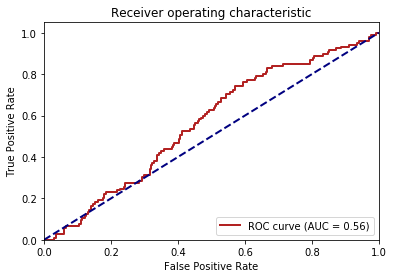

Average precision-recall score: 0.09


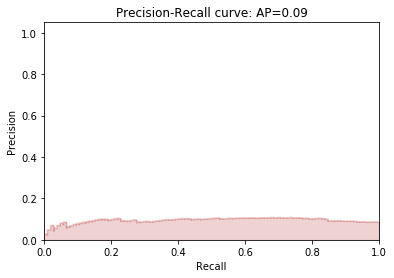

Best F1 score of  0.18886198547215496  achieved at threshold of  126.03246744265829
Corresponding vales are: Precision  0.10818307905686546  Recall:  0.7428571428571429


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

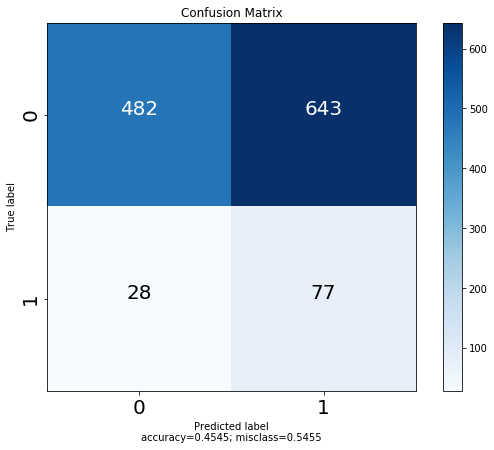

In [28]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

np.save("Results/curves/"+grid_type+"/statistical_mean/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/statistical_mean/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/statistical_mean/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/statistical_mean/recall.npy", recall)



In [348]:
print (mean_grid.shape)
mean_grid = np.multiply(mean_grid,255/np.max(mean_grid))
print(mean_grid.dtype)
cv2.imwrite("mean_grid.jpg", mean_grid.reshape((34,60)))




(2, 34, 60)
float64


ValueError: cannot reshape array of size 4080 into shape (34,60)

In [349]:
maxi = np.amax(mean_grid)
print (maxi)

255.0


## Multivariate Gaussian

In [350]:
# [7]
def covariance_matrix(X):
    m, n = X.shape 
    tmp_mat = np.zeros((n, n))
    mu = X.mean(axis=0)
    for i in range(m):
        tmp_mat += np.outer(X[i] - mu, X[i] - mu)
    return tmp_mat / m

In [351]:
# [7]
def multi_gauss_params(X):
    
    #cov_mat = covariance_matrix(X)
    cov_mat = np.cov(X, rowvar=False)
    print('Covariance matrix done')
    cov_mat_inv = np.linalg.pinv(cov_mat)
    print('Covariance matrix inverse done')
    cov_mat_det = np.linalg.det(cov_mat)
    print('Covariance matrix determinant done')
    
    return cov_mat, cov_mat_inv, cov_mat_det


In [352]:
# [7]
def multi_gauss(x, cov_mat, cov_mat_inv, cov_mat_det):
    n = len(cov_mat)
    return (np.exp(-0.5 * np.dot(x, np.dot(cov_mat_inv, x.T))) )
            #/ (2. * np.pi)**(n/2.) 
            #/ np.sqrt(cov_mat_det))

In [353]:


X_train_flat, X_test_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))), X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

X_train_flat = np.array(X_train_flat, dtype=np.float64)
X_test_flat = np.array(X_test_flat, dtype=np.float64)

#X_train_flat = np.multiply(X_train_flat, 2)
#X_test_flat = np.multiply(X_test_flat, 2)

print(X_train_flat)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [354]:
cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(X_train_flat)



Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done


In [355]:
print(cov_mat_inv)
print(cov_mat_det)

[[    0.             0.             0.         ...     0.
      0.             0.        ]
 [    0.             0.             0.         ...     0.
      0.             0.        ]
 [    0.             0.             0.         ...     0.
      0.             0.        ]
 ...
 [    0.             0.             0.         ... 10062.10977641
  -4322.66441484   423.22265729]
 [    0.             0.             0.         ... -4322.66441484
  12730.44890219 -7257.78858528]
 [    0.             0.             0.         ...   423.22265729
  -7257.78858527  9636.22137763]]
0.0


In [356]:

threshold = 900

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test_flat,Id_test,sec_count_test)):
    grid_numeric = np.array(grid, dtype = np.float64)
    one_minus_prob = 1-multi_gauss(grid, cov_mat, cov_mat_inv, cov_mat_det)
    print(one_minus_prob)
    scores[i] = one_minus_prob
    dists = dists + one_minus_prob
    interval_timer = interval_timer+1 
    if one_minus_prob > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])



1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


ROC_AUC: 0.50


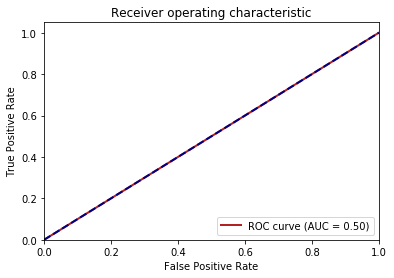

Average precision-recall score: 0.09


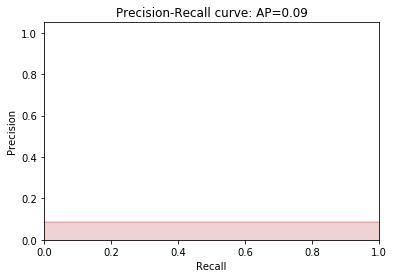

Best F1 score of  0.15730337078651685  achieved at threshold of  1.0
Corresponding vales are: Precision  0.08536585365853659  Recall:  1.0


<Figure size 432x288 with 0 Axes>

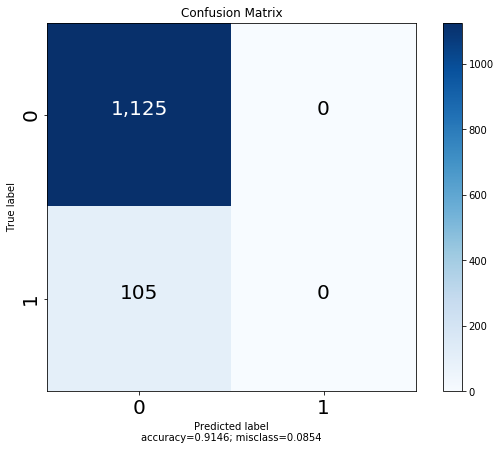

In [357]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

np.save("Results/curves/"+grid_type+"/mult_gauss/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/mult_gauss/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/mult_gauss/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/mult_gauss/recall.npy", recall)



### Modified Multivariate Gaussian

In [358]:
coordinates_train = []


for index, loc in np.ndenumerate(X_train):
    if loc == 1:
        if X_train.shape[1] == 2:
            coordinates_train.append([index[1],index[2],index[3]])
        else:
            coordinates_train.append([index[2],index[3]])


        
coordinates_train = np.array(coordinates_train, dtype=np.int8)


In [359]:
print(coordinates_train.shape)
print(coordinates_train.dtype)
print(coordinates_train)

(2151487, 3)
int8
[[ 0  4 37]
 [ 0  4 38]
 [ 0  4 39]
 ...
 [ 1 33 57]
 [ 1 33 58]
 [ 1 33 59]]


In [360]:
cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(coordinates_train)




Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done


In [361]:
print(cov_mat_inv)
print(cov_mat_det)

[[ 4.38391775e+00  2.26027227e-03 -3.45664458e-02]
 [ 2.26027227e-03  1.42690883e-02  1.55254499e-03]
 [-3.45664458e-02  1.55254499e-03  4.50741366e-03]]
3935.8119444027093


In [362]:

threshold = 900

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test,Id_test,sec_count_test)):
    probabilities = []
    
    for index, loc in np.ndenumerate(grid):
        if loc == 1:
            
            if X_train.shape[1] == 2:
                one_minus_prob = 1-multi_gauss(np.array([index[0],index[1],index[2]]), cov_mat, cov_mat_inv, cov_mat_det)
            else:
                one_minus_prob = 1-multi_gauss(np.array([index[1],index[2]]), cov_mat, cov_mat_inv, cov_mat_det)

            probabilities.append(one_minus_prob)
    
    if len(probabilities) > 0:
        score = max(probabilities)
    else:
        score = 0
    #print(score)
    scores[i] = score
    dists = dists + score
    interval_timer = interval_timer+1 
    if score > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])




0.599976629503949


ROC_AUC: 0.53


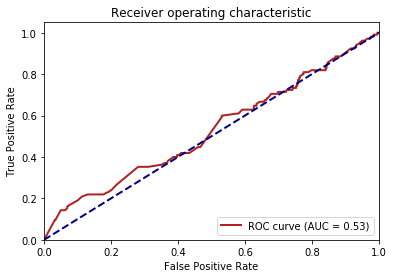

Average precision-recall score: 0.11


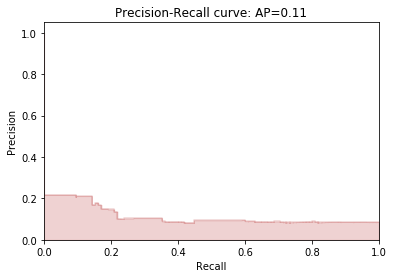

Best F1 score of  0.17254901960784316  achieved at threshold of  0.9999999750881601
Corresponding vales are: Precision  0.14666666666666667  Recall:  0.20952380952380953


<Figure size 432x288 with 0 Axes>

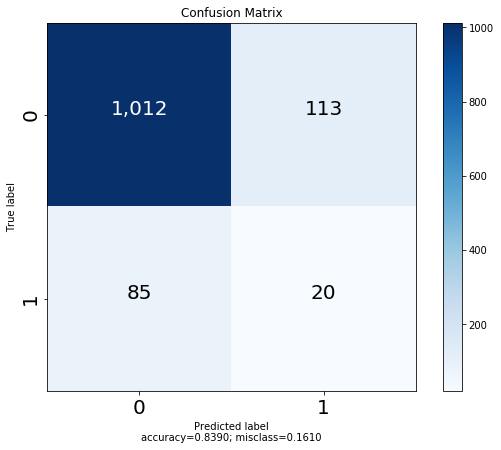

In [363]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/mult_gauss_modified/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/mult_gauss_modified/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/mult_gauss_modified/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/mult_gauss_modified/recall.npy", recall)




## Autoencoder

### 1D Autoencoder

In [364]:


X_train_flat, X_test_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))), X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


In [365]:
input_dim = np.prod(grids.shape[1:])
encoding_dim = 42

print(input_dim)

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

4080


In [366]:
nb_epoch = 50
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="models/model.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train_flat, X_train_flat,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_flat, X_test_flat),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 6559 samples, validate on 9838 samples
Epoch 1/50
6559/6559 [==============================] - 14s 2ms/step - loss: 0.0820 - acc: 1.5246e-04 - val_loss: 0.0803 - val_acc: 1.0165e-04
Epoch 2/50
6559/6559 [==============================] - 4s 680us/step - loss: 0.0714 - acc: 6.0985e-04 - val_loss: 0.0742 - val_acc: 5.0823e-04
Epoch 3/50
6559/6559 [==============================] - 4s 674us/step - loss: 0.0673 - acc: 6.0985e-04 - val_loss: 0.0718 - val_acc: 0.0016
Epoch 4/50
6559/6559 [==============================] - 4s 671us/step - loss: 0.0643 - acc: 0.0014 - val_loss: 0.0691 - val_acc: 3.0494e-04
Epoch 5/50
6559/6559 [==============================] - 4s 676us/step - loss: 0.0620 - acc: 6.0985e-04 - val_loss: 0.0679 - val_acc: 0.0000e+00
Epoch 6/50
6559/6559 [==============================] - 5s 699us/step - loss: 0.0606 - acc: 6.0985e-04 - val_loss: 0.0651 - val_acc: 0.0000e+00
Epoch 7/50
6559/6559 [==============================] - 5s 793us/step - loss: 0.0587 - acc: 1.524

In [367]:
autoencoder = load_model('models/model.h5')

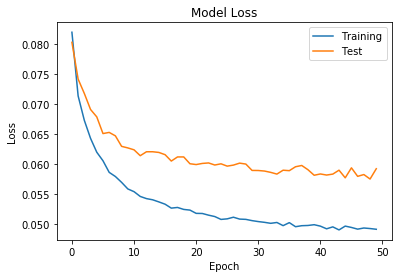

In [368]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper right');

In [369]:
predictions = autoencoder.predict(X_test_flat)

In [370]:
mse = np.mean(np.power(X_test_flat - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'frameId': Id_test,
                        'second_count': sec_count_test})


In [371]:
threshold = 0.08
interval = 2  # in seconds

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


Anomaly detected at :  28  mins  22  seconds
Anomaly detected at :  28  mins  59  seconds
Anomaly detected at :  29  mins  18  seconds
Anomaly detected at :  29  mins  50  seconds
Anomaly detected at :  30  mins  0  seconds
Anomaly detected at :  30  mins  15  seconds
Anomaly detected at :  31  mins  29  seconds
Anomaly detected at :  31  mins  53  seconds
Anomaly detected at :  32  mins  2  seconds
Anomaly detected at :  32  mins  9  seconds
Anomaly detected at :  32  mins  37  seconds
Anomaly detected at :  32  mins  59  seconds
Anomaly detected at :  33  mins  35  seconds
Anomaly detected at :  36  mins  10  seconds
Anomaly detected at :  37  mins  47  seconds
Anomaly detected at :  37  mins  52  seconds
Anomaly detected at :  38  mins  15  seconds
Anomaly detected at :  38  mins  51  seconds
Anomaly detected at :  38  mins  58  seconds
Anomaly detected at :  39  mins  29  seconds
Anomaly detected at :  41  mins  9  seconds
Anomaly detected at :  41  mins  17  seconds
Anomaly detect

In [372]:


y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(error_df.reconstruction_error.values[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.52


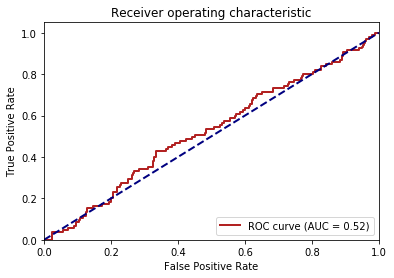

Average precision-recall score: 0.09


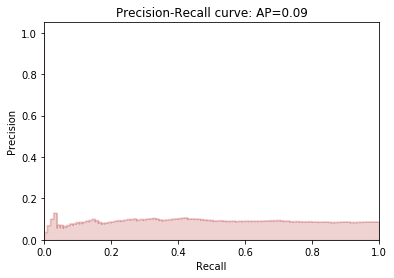

Best F1 score of  0.17077798861480079  achieved at threshold of  0.057949308305978775
Corresponding vales are: Precision  0.1066350710900474  Recall:  0.42857142857142855


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

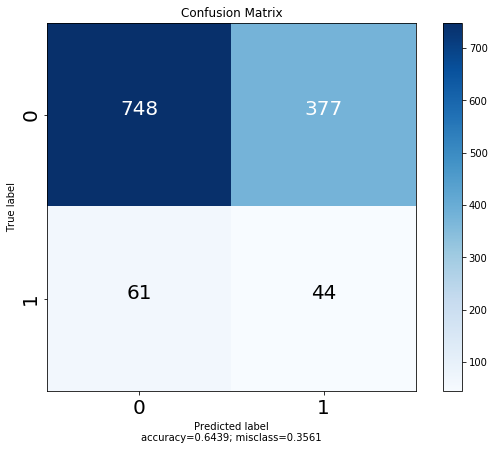

In [373]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/1D_autoencoder/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/1D_autoencoder/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/1D_autoencoder/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/1D_autoencoder/recall.npy", recall)




### 2D Convolutional Autoencoder

In [374]:
input_dim = (grids.shape[1], grids.shape[2], grids.shape[3])

print(input_dim)


input_img = Input(shape=input_dim)  # adapt this if using `channels_first` image data format

x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(input_img)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
encoded = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)


x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(encoded)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(8, (4, 3), activation='relu', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
decoded = Conv2D(grids.shape[1], (3, 3), activation='sigmoid', padding='same', data_format="channels_first")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(2, 34, 60)


In [375]:
checkpointer = ModelCheckpoint(filepath="models/model_2D_conv.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpointer]).history

Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 102s 16ms/step - loss: 0.2927 - val_loss: 0.2030
Epoch 2/10
6559/6559 [==============================] - 97s 15ms/step - loss: 0.1761 - val_loss: 0.1584
Epoch 3/10
6559/6559 [==============================] - 97s 15ms/step - loss: 0.1282 - val_loss: 0.1207
Epoch 4/10
6559/6559 [==============================] - 97s 15ms/step - loss: 0.1125 - val_loss: 0.1122
Epoch 5/10
6559/6559 [==============================] - 93s 14ms/step - loss: 0.1064 - val_loss: 0.1076
Epoch 6/10
6559/6559 [==============================] - 92s 14ms/step - loss: 0.1027 - val_loss: 0.1049
Epoch 7/10
6559/6559 [==============================] - 92s 14ms/step - loss: 0.0997 - val_loss: 0.1021
Epoch 8/10
6559/6559 [==============================] - 92s 14ms/step - loss: 0.0974 - val_loss: 0.1000
Epoch 9/10
6559/6559 [==============================] - 91s 14ms/step - loss: 0.0955 - val_loss: 0.0985
Epoch 10/10
655

In [376]:
autoencoder = load_model('models/model_2D_conv.h5')

In [377]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 2, 34, 60)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 34, 60)         152       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 17, 30)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 4, 17, 30)         292       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 9, 15)          0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 4, 9, 15)          148       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 4, 5, 8)           0         
__________

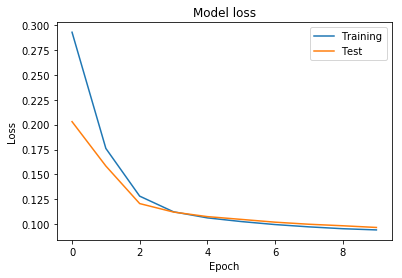

In [378]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper right');

In [379]:
predictions = autoencoder.predict(X_test)

In [380]:
mse = np.mean(np.power(X_test - predictions, 2), axis=(1,2,3))
print(mse.shape)
error_df = pd.DataFrame({'reconstruction_error': mse.reshape((len(mse),)),
                        'frameId': Id_test,
                        'second_count': sec_count_test})




(9838,)


In [381]:
threshold = 0.015
interval = 1

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


    



Anomaly detected at :  28  mins  43  seconds
Anomaly detected at :  44  mins  5  seconds
Anomaly detected at :  45  mins  43  seconds
Anomaly detected at :  53  mins  24  seconds
Anomaly detected at :  57  mins  52  seconds
Anomaly detected at :  61  mins  42  seconds
Anomaly detected at :  62  mins  39  seconds
Anomaly detected at :  62  mins  43  seconds
Anomaly detected at :  62  mins  46  seconds
Anomaly detected at :  62  mins  49  seconds
Anomaly detected at :  63  mins  33  seconds


In [382]:


y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(error_df.reconstruction_error.values[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.55


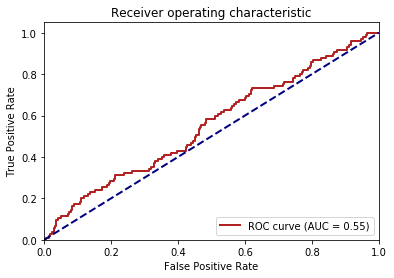

Average precision-recall score: 0.11


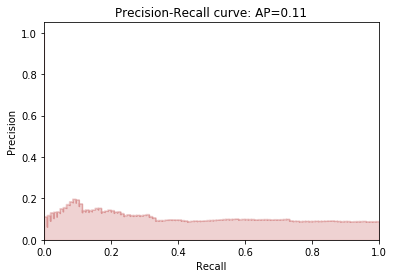

Best F1 score of  0.17553191489361702  achieved at threshold of  0.0437348298728466
Corresponding vales are: Precision  0.12177121771217712  Recall:  0.3142857142857143


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

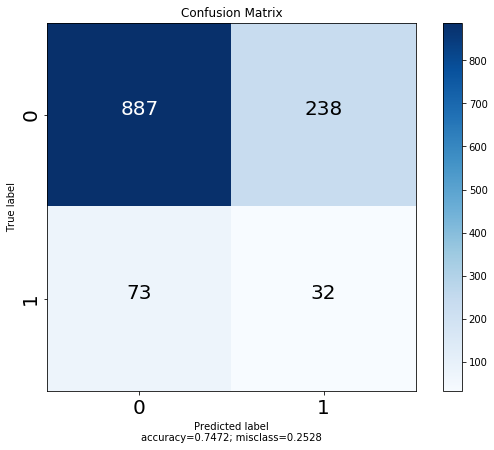

In [383]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/2D_autoencoder/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/2D_autoencoder/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/2D_autoencoder/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/2D_autoencoder/recall.npy", recall)






## Region Based Approach

### Variance

In [30]:
vertical_divisions = 10  # Actual number of divisions will vary after precision loss from rounding
horizontal_divisions = 10

#region_w = int(round(X_train.shape[3]/horizontal_divisions))
#region_h = int(round(X_train.shape[2]/vertical_divisions))

region_w = 3
region_h = 3



In [31]:
print(X_test.shape)

(9838, 1, 34, 60)


In [32]:

if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[1]/region_h)),int(ceil(X_train.shape[2]/region_w))), dtype = np.float64)
    
else:
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
    

num_r_x = region_scores.shape[2]
num_r_y = region_scores.shape[1]
region_scores.shape


(9838, 12, 20)

In [387]:
mean_grid = np.mean(X_train, axis=0)
print(mean_grid.shape)


for i in range(num_r_x): # horizontal index
    for j in range(num_r_y): # vertical index
        
        
        if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
            X_train_r = X_train[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]

        else:
            X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        
        
        ######################################################################
        
        
        print(X_test_r.shape)
        
        if grid_type == 'flow':
            var = np.mean(np.amax(np.power(X_test_r - mean_grid_r, 2), axis=1), axis=(1,2))

        else:
            var = np.amax(np.amax(np.power(X_test_r - mean_grid_r, 2), axis=3), axis=(1,2))
        
        print(var)
        
        error_df = pd.DataFrame({'variance': var})
        
        region_scores[:,j,i] = error_df.variance.values




        

(2, 34, 60)
(9838, 2, 3, 3)
[9.29789697e-08 9.29789697e-08 9.29789697e-08 ... 9.29789697e-08
 9.29789697e-08 9.29789697e-08]
(9838, 2, 3, 3)
[2.81261383e-06 2.81261383e-06 2.81261383e-06 ... 2.81261383e-06
 2.81261383e-06 2.81261383e-06]
(9838, 2, 3, 3)
[3.9074412e-05 3.9074412e-05 3.9074412e-05 ... 3.9074412e-05 3.9074412e-05
 3.9074412e-05]
(9838, 2, 3, 3)
[0.01314499 0.01314499 0.01314499 ... 0.01314499 0.01314499 0.01314499]
(9838, 2, 3, 3)
[0.02305916 0.02305916 0.8731804  ... 0.02305916 0.02305916 0.02305916]
(9838, 2, 3, 3)
[0.0404403  0.0404403  0.80640893 ... 0.0404403  0.80367302 0.70878994]
(9838, 2, 3, 3)
[0.01483947 0.01483947 0.93404165 ... 0.01483947 0.99512716 0.99512716]
(9838, 2, 3, 3)
[0.01040344 0.01040344 0.88920961 ... 0.01040344 0.99908544 0.99725756]
(9838, 2, 3, 3)
[0.01640149 0.01640149 0.81932996 ... 0.01640149 0.01640149 0.01640149]
(9838, 2, 3, 3)
[0.01647969 0.81326903 0.81326903 ... 0.01647969 0.01647969 0.01647969]
(9838, 2, 3, 3)
[0.01671539 0.81464454 

(9838, 2, 3, 3)
[0.73130008 0.73130008 0.73130008 ... 0.03111655 0.03111655 0.03111655]
(9838, 2, 3, 3)
[0.0193761 0.0193761 0.0193761 ... 0.0193761 0.0193761 0.0193761]
(9838, 2, 3, 3)
[0.00621306 0.00621306 0.00621306 ... 0.87033339 0.8731804  0.8731804 ]
(9838, 2, 3, 3)
[0.00893528 0.00893528 0.00893528 ... 0.85616804 0.87090242 0.87090242]
(9838, 2, 3, 3)
[0.7165123  0.7165123  0.02676235 ... 0.79277589 0.8138191  0.8138191 ]
(9838, 2, 3, 3)
[0.73704804 0.73704804 0.03160253 ... 0.03160253 0.03160253 0.72116581]
(9838, 2, 3, 3)
[0.8006689  0.8006689  0.02352452 ... 0.02352452 0.02352452 0.02352452]
(9838, 2, 3, 3)
[0.00931391 0.00931391 0.00931391 ... 0.00931391 0.00931391 0.00931391]
(9838, 2, 3, 3)
[0.00165709 0.00165709 0.00165709 ... 0.00165709 0.00165709 0.00165709]
(9838, 2, 1, 3)
[0.00126193 0.00126193 0.00126193 ... 0.00126193 0.00126193 0.00126193]
(9838, 2, 3, 3)
[0.0001563 0.0001563 0.0001563 ... 0.0001563 0.0001563 0.0001563]
(9838, 2, 3, 3)
[0.00149966 0.00149966 0.001

[0.4627899 0.4627899 0.4627899 ... 0.3780778 0.3780778 0.3780778]
(9838, 2, 3, 3)
[0.56427377 0.56427377 0.56427377 ... 0.13523196 0.13523196 0.13523196]
(9838, 2, 3, 3)
[0.00687896 0.00687896 0.00687896 ... 0.00687896 0.00687896 0.00687896]
(9838, 2, 3, 3)
[0.00645574 0.00645574 0.00645574 ... 0.00645574 0.00645574 0.00645574]
(9838, 2, 3, 3)
[0.78546237 0.78546237 0.78546237 ... 0.02973377 0.02973377 0.02973377]
(9838, 2, 3, 3)
[0.79576518 0.79576518 0.79576518 ... 0.02787103 0.02787103 0.02787103]
(9838, 2, 1, 3)
[0.80750459 0.80750459 0.80750459 ... 0.02209703 0.02209703 0.02209703]
(9838, 2, 3, 3)
[0.26839319 0.85222257 0.85222257 ... 0.26839319 0.26839319 0.26839319]
(9838, 2, 3, 3)
[0.29459457 0.29459457 0.63848847 ... 0.29459457 0.2906359  0.2906359 ]
(9838, 2, 3, 3)
[0.37527065 0.37527065 0.69677568 ... 0.71599618 0.67005669 0.67005669]
(9838, 2, 3, 3)
[0.06183476 0.06183476 0.06183476 ... 0.72791413 0.59891883 0.59891883]
(9838, 2, 3, 3)
[0.06459456 0.06459456 0.06459456 ... 

In [388]:
scores = np.amax(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.54


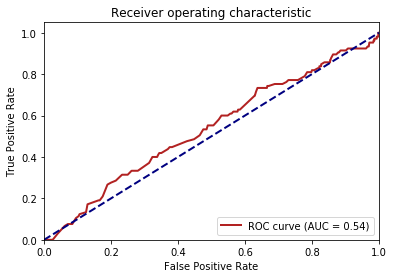

Average precision-recall score: 0.10


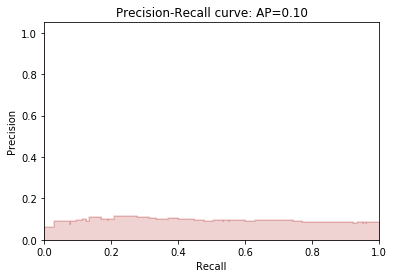

Best F1 score of  0.17130144605116795  achieved at threshold of  0.981788209202031
Corresponding vales are: Precision  0.09697732997481108  Recall:  0.7333333333333333


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

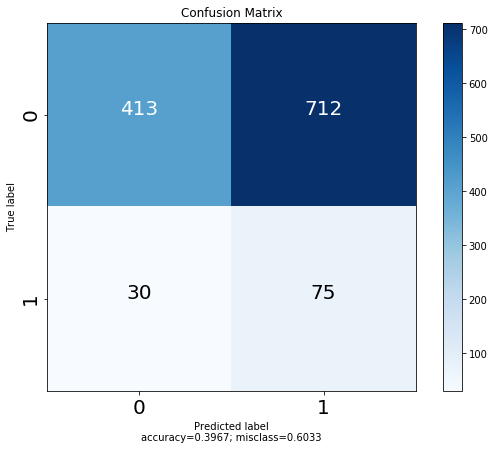

In [389]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)


np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_var_from_mean/recall.npy", recall)





In [390]:
threshold = 0.4
interval = 1

y_pred = [1 if e > threshold else 0 for e in scores]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')

### Multivariate Gaussian

In [391]:
def multi_gauss(x, cov_mat, cov_mat_inv, cov_mat_det):
    n = len(cov_mat)
    return (np.exp(-0.5 * np.dot(x, np.dot(cov_mat_inv, x.T))) )
            #/ (2. * np.pi)**(n/2.) 
            #/ np.sqrt(cov_mat_det))

In [392]:
vertical_divisions = 10  # Actual number of divisions will vary after precision loss from rounding
horizontal_divisions = 10

#region_w = int(round(X_train.shape[3]/horizontal_divisions))
#region_h = int(round(X_train.shape[2]/vertical_divisions))

region_w = 3
region_h = 3



In [393]:
print(X_test.shape)

(9838, 2, 34, 60)


In [394]:

if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[1]/region_h)),int(ceil(X_train.shape[2]/region_w))), dtype = np.float64)
    
else:
    region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
    

num_r_x = region_scores.shape[2]
num_r_y = region_scores.shape[1]
region_scores.shape


(9838, 12, 20)

In [395]:
mean_grid = np.mean(X_train, axis=0)
print(mean_grid.shape)


for i in range(num_r_x): # horizontal index
    for j in range(num_r_y): # vertical index
        
        
        if (grid_type == 'flow_avg') or (grid_type == 'flow_max'):
            X_train_r = X_train[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]

        else:
            X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
            # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')

            mean_grid_r = mean_grid[:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        
        
        X_train_r_flat, X_test_r_flat = X_train_r.reshape((len(X_train_r), np.prod(X_train_r.shape[1:]))), X_test_r.reshape((len(X_test_r), np.prod(X_test_r.shape[1:])))
        
        ######################################################################
        
        
        print(X_test_r.shape)
        print(X_test_r_flat.shape)
        
        probabilities = np.zeros((X_test_r.shape[0]))
        
        cov_mat, cov_mat_inv, cov_mat_det = multi_gauss_params(X_train_r_flat)
        
        for k, grid in enumerate(X_test_r_flat):
            one_minus_prob = 1-multi_gauss(grid, cov_mat, cov_mat_inv, cov_mat_det)
            probabilities[k] = one_minus_prob
        
        
        
        error_df = pd.DataFrame({'probabilities': probabilities})
        
        region_scores[:,j,i] = error_df.probabilities.values




        

(2, 34, 60)
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance

(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inve

(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inverse done
Covariance matrix determinant done
(9838, 2, 3, 3)
(9838, 18)
Covariance matrix done
Covariance matrix inve

In [396]:
print(region_scores.shape)
scores = np.mean(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

(9838, 12, 20)


ROC_AUC: 0.55


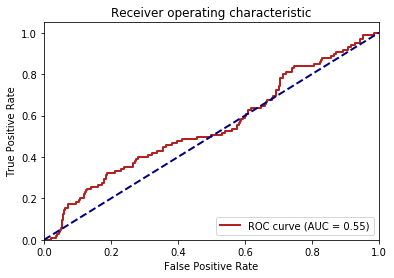

Average precision-recall score: 0.11


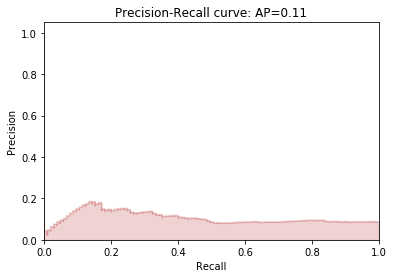

Best F1 score of  0.19373219373219375  achieved at threshold of  0.411530581801115
Corresponding vales are: Precision  0.13821138211382114  Recall:  0.3238095238095238


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

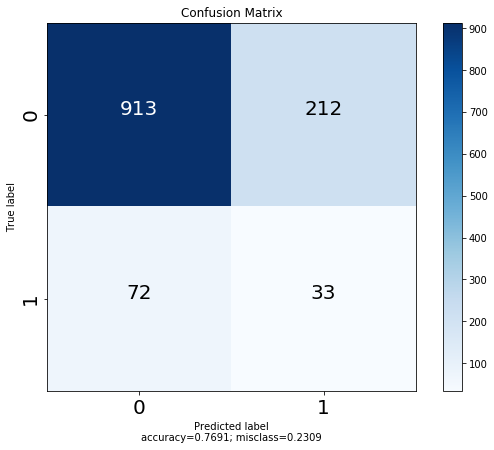

In [397]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_mult_gauss/recall.npy", recall)





In [398]:
threshold = 0.4
interval = 1

y_pred = [1 if e > threshold else 0 for e in scores]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')

Anomaly detected at :  28  mins  4  seconds
Anomaly detected at :  28  mins  9  seconds
Anomaly detected at :  28  mins  18  seconds
Anomaly detected at :  28  mins  23  seconds
Anomaly detected at :  29  mins  4  seconds
Anomaly detected at :  29  mins  7  seconds
Anomaly detected at :  29  mins  9  seconds
Anomaly detected at :  29  mins  14  seconds
Anomaly detected at :  29  mins  16  seconds
Anomaly detected at :  29  mins  24  seconds
Anomaly detected at :  29  mins  27  seconds
Anomaly detected at :  29  mins  48  seconds
Anomaly detected at :  29  mins  50  seconds
Anomaly detected at :  29  mins  52  seconds
Anomaly detected at :  30  mins  0  seconds
Anomaly detected at :  30  mins  4  seconds
Anomaly detected at :  30  mins  11  seconds
Anomaly detected at :  30  mins  20  seconds
Anomaly detected at :  30  mins  26  seconds
Anomaly detected at :  30  mins  33  seconds
Anomaly detected at :  30  mins  48  seconds
Anomaly detected at :  30  mins  50  seconds
Anomaly detected 

### Autoencoder

In [33]:

region_scores = np.zeros((X_test.shape[0],int(ceil(X_train.shape[2]/region_h)),int(ceil(X_train.shape[3]/region_w))), dtype = np.float64)
region_scores.shape


(9838, 12, 20)

In [34]:
for i in range(int(ceil(X_train.shape[3]/region_w))): # horizontal index
    for j in range(int(ceil(X_train.shape[2]/region_h))): # vertical index

        X_train_r = X_train[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        X_test_r = X_test[:,:,region_h*j:region_h*(j+1),region_w*i:region_w*(i+1)]
        # print('(',region_h*j,'-',region_h*(j+1),')   (',region_w*i,'-',region_w*(i+1),')')
        
        X_train_r_flat = X_train_r.reshape((len(X_train_r), np.prod(X_train_r.shape[1:])))
        X_test_r_flat = X_test_r.reshape((len(X_test_r), np.prod(X_test_r.shape[1:])))
        
        ######################################################################
        
        input_dim = np.prod(X_train_r.shape[1:])
        encoding_dim = int(round(input_dim/2))

        # print(input_dim)

        input_layer = Input(shape=(input_dim, ))

        encoder = Dense(encoding_dim, activation="tanh", 
                        activity_regularizer=regularizers.l1(10e-5))(input_layer)
        encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

        decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
        decoder = Dense(input_dim, activation='relu')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        
        nb_epoch = 10
        batch_size = 32

        autoencoder.compile(optimizer='adam', 
                            loss='mean_squared_error', 
                            metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/model_r.h5",
                                       verbose=0,
                                       save_best_only=True)


        history = autoencoder.fit(X_train_r_flat, X_train_r_flat,
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(X_test_r_flat, X_test_r_flat),
                            verbose=1,
                            callbacks=[checkpointer]).history
        
        autoencoder = load_model('models/model_r.h5')
        
        predictions = autoencoder.predict(X_test_r_flat)
        
        mse = np.mean(np.power(X_test_r_flat - predictions, 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse})
        
        region_scores[:,j,i] = error_df.reconstruction_error.values




        

Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 2s 238us/step - loss: 1.0386e-04 - acc: 0.9119 - val_loss: 3.5357e-05 - val_acc: 0.0000e+00
Epoch 2/10
6559/6559 [==============================] - 1s 97us/step - loss: 9.3130e-05 - acc: 0.8143 - val_loss: 2.9112e-05 - val_acc: 0.9999
Epoch 3/10
6559/6559 [==============================] - 1s 96us/step - loss: 8.2270e-05 - acc: 0.8828 - val_loss: 2.6156e-05 - val_acc: 0.9999
Epoch 4/10
6559/6559 [==============================] - 1s 96us/step - loss: 7.2647e-05 - acc: 0.8972 - val_loss: 2.2836e-05 - val_acc: 0.9999
Epoch 5/10
6559/6559 [==============================] - 1s 97us/step - loss: 6.3864e-05 - acc: 0.9072 - val_loss: 2.0827e-05 - val_acc: 0.9999
Epoch 6/10
6559/6559 [==============================] - 1s 96us/step - loss: 5.6758e-05 - acc: 0.9610 - val_loss: 1.9504e-05 - val_acc: 0.9999
Epoch 7/10
6559/6559 [==============================] - 1s 108us/step - loss: 5.0998e-05 

6559/6559 [==============================] - 1s 112us/step - loss: 0.0856 - acc: 0.1075 - val_loss: 0.0423 - val_acc: 0.0534
Epoch 8/10
6559/6559 [==============================] - 1s 112us/step - loss: 0.0849 - acc: 0.1358 - val_loss: 0.0418 - val_acc: 0.0534
Epoch 9/10
6559/6559 [==============================] - 1s 112us/step - loss: 0.0842 - acc: 0.0890 - val_loss: 0.0413 - val_acc: 0.0506
Epoch 10/10
6559/6559 [==============================] - 1s 112us/step - loss: 0.0834 - acc: 0.1113 - val_loss: 0.0407 - val_acc: 0.0508
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 2s 376us/step - loss: 0.0298 - acc: 0.0313 - val_loss: 0.0073 - val_acc: 0.0298
Epoch 2/10
6559/6559 [==============================] - 1s 114us/step - loss: 0.0247 - acc: 0.0669 - val_loss: 0.0068 - val_acc: 0.0298
Epoch 3/10
6559/6559 [==============================] - 1s 120us/step - loss: 0.0241 - acc: 0.3482 - val_loss: 0.0066 - val_acc: 0.9666
Epoch 4/10

6559/6559 [==============================] - 1s 138us/step - loss: 1.0323e-04 - acc: 0.9997 - val_loss: 8.5662e-07 - val_acc: 1.0000
Epoch 3/10
6559/6559 [==============================] - 1s 154us/step - loss: 1.0326e-04 - acc: 0.9997 - val_loss: 1.2448e-06 - val_acc: 1.0000
Epoch 4/10
6559/6559 [==============================] - 1s 181us/step - loss: 1.0325e-04 - acc: 0.9997 - val_loss: 2.8986e-07 - val_acc: 1.0000
Epoch 5/10
6559/6559 [==============================] - 1s 217us/step - loss: 1.0318e-04 - acc: 0.9997 - val_loss: 6.9230e-07 - val_acc: 1.0000
Epoch 6/10
6559/6559 [==============================] - 1s 170us/step - loss: 1.0304e-04 - acc: 0.9997 - val_loss: 6.0186e-07 - val_acc: 1.0000
Epoch 7/10
6559/6559 [==============================] - 1s 147us/step - loss: 1.0322e-04 - acc: 0.9997 - val_loss: 7.2404e-07 - val_acc: 1.0000
Epoch 8/10
6559/6559 [==============================] - 1s 134us/step - loss: 1.0320e-04 - acc: 0.9997 - val_loss: 6.1009e-07 - val_acc: 1.0000
Epo

Epoch 9/10
6559/6559 [==============================] - 1s 155us/step - loss: 0.0510 - acc: 0.1273 - val_loss: 0.0429 - val_acc: 0.0937
Epoch 10/10
6559/6559 [==============================] - 1s 163us/step - loss: 0.0499 - acc: 0.1281 - val_loss: 0.0421 - val_acc: 0.0937
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 4s 616us/step - loss: 0.1486 - acc: 0.1584 - val_loss: 0.0994 - val_acc: 0.0887
Epoch 2/10
6559/6559 [==============================] - 1s 155us/step - loss: 0.1330 - acc: 0.1538 - val_loss: 0.0931 - val_acc: 0.1446
Epoch 3/10
6559/6559 [==============================] - 1s 145us/step - loss: 0.1242 - acc: 0.2077 - val_loss: 0.0875 - val_acc: 0.1316
Epoch 4/10
6559/6559 [==============================] - 1s 143us/step - loss: 0.1160 - acc: 0.1448 - val_loss: 0.0802 - val_acc: 0.0646
Epoch 5/10
6559/6559 [==============================] - 1s 144us/step - loss: 0.0975 - acc: 0.1560 - val_loss: 0.0612 - val_acc: 0.0637

Epoch 6/10
6559/6559 [==============================] - 1s 186us/step - loss: 4.1969e-04 - acc: 0.8626 - val_loss: 2.0823e-04 - val_acc: 0.9995
Epoch 7/10
6559/6559 [==============================] - 1s 164us/step - loss: 4.1251e-04 - acc: 0.9355 - val_loss: 2.0622e-04 - val_acc: 0.9996
Epoch 8/10
6559/6559 [==============================] - 1s 162us/step - loss: 4.0717e-04 - acc: 0.9306 - val_loss: 2.0433e-04 - val_acc: 0.9996
Epoch 9/10
6559/6559 [==============================] - 1s 162us/step - loss: 4.0283e-04 - acc: 0.8674 - val_loss: 2.0343e-04 - val_acc: 0.9996
Epoch 10/10
6559/6559 [==============================] - 1s 163us/step - loss: 3.9912e-04 - acc: 0.9989 - val_loss: 2.0209e-04 - val_acc: 0.9996
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 5s 807us/step - loss: 1.9259e-04 - acc: 0.8045 - val_loss: 6.6213e-05 - val_acc: 0.9999
Epoch 2/10
6559/6559 [==============================] - 1s 172us/step - loss: 1.8629e-0

6559/6559 [==============================] - 1s 176us/step - loss: 0.2080 - acc: 0.1563 - val_loss: 0.1194 - val_acc: 0.6755
Epoch 3/10
6559/6559 [==============================] - 1s 177us/step - loss: 0.1918 - acc: 0.4883 - val_loss: 0.1123 - val_acc: 0.6704
Epoch 4/10
6559/6559 [==============================] - 1s 178us/step - loss: 0.1840 - acc: 0.4813 - val_loss: 0.1071 - val_acc: 0.6710
Epoch 5/10
6559/6559 [==============================] - 1s 175us/step - loss: 0.1783 - acc: 0.3947 - val_loss: 0.1033 - val_acc: 0.0873
Epoch 6/10
6559/6559 [==============================] - 1s 180us/step - loss: 0.1471 - acc: 0.0964 - val_loss: 0.0783 - val_acc: 0.0561
Epoch 7/10
6559/6559 [==============================] - 1s 176us/step - loss: 0.1214 - acc: 0.2782 - val_loss: 0.0740 - val_acc: 0.6652
Epoch 8/10
6559/6559 [==============================] - 1s 176us/step - loss: 0.1170 - acc: 0.4835 - val_loss: 0.0719 - val_acc: 0.6655
Epoch 9/10
6559/6559 [==============================] - 1s 

6559/6559 [==============================] - 1s 192us/step - loss: 0.0018 - acc: 0.6896 - val_loss: 9.7287e-04 - val_acc: 0.9983
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0013 - acc: 0.8619 - val_loss: 3.8775e-04 - val_acc: 0.9994
Epoch 2/10
6559/6559 [==============================] - 1s 197us/step - loss: 0.0013 - acc: 0.8084 - val_loss: 3.7324e-04 - val_acc: 0.9994
Epoch 3/10
6559/6559 [==============================] - 1s 198us/step - loss: 0.0012 - acc: 0.5900 - val_loss: 3.5211e-04 - val_acc: 0.9995
Epoch 4/10
6559/6559 [==============================] - 1s 197us/step - loss: 0.0011 - acc: 0.6487 - val_loss: 3.1920e-04 - val_acc: 0.9995
Epoch 5/10
6559/6559 [==============================] - 1s 197us/step - loss: 9.9479e-04 - acc: 0.6817 - val_loss: 2.8524e-04 - val_acc: 0.9993
Epoch 6/10
6559/6559 [==============================] - 1s 197us/step - loss: 8.9808e-04 - acc: 0.6335 - val_loss: 2.6310

6559/6559 [==============================] - 1s 226us/step - loss: 0.1114 - acc: 0.0671 - val_loss: 0.0777 - val_acc: 0.0630
Epoch 7/10
6559/6559 [==============================] - 1s 226us/step - loss: 0.1042 - acc: 0.0636 - val_loss: 0.0744 - val_acc: 0.0414
Epoch 8/10
6559/6559 [==============================] - 1s 226us/step - loss: 0.1000 - acc: 0.0425 - val_loss: 0.0729 - val_acc: 0.0411
Epoch 9/10
6559/6559 [==============================] - 1s 227us/step - loss: 0.0979 - acc: 0.0439 - val_loss: 0.0722 - val_acc: 0.0358
Epoch 10/10
6559/6559 [==============================] - 1s 227us/step - loss: 0.0969 - acc: 0.0468 - val_loss: 0.0718 - val_acc: 0.0295
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.3211 - acc: 0.0409 - val_loss: 0.2389 - val_acc: 0.0123
Epoch 2/10
6559/6559 [==============================] - 2s 234us/step - loss: 0.2809 - acc: 0.1644 - val_loss: 0.2322 - val_acc: 0.0799
Epoch 3/10
6

Epoch 4/10
6559/6559 [==============================] - 2s 234us/step - loss: 0.0017 - acc: 0.9758 - val_loss: 9.2796e-04 - val_acc: 0.9975
Epoch 5/10
6559/6559 [==============================] - 2s 236us/step - loss: 0.0016 - acc: 0.9755 - val_loss: 9.1420e-04 - val_acc: 0.9974
Epoch 6/10
6559/6559 [==============================] - 2s 234us/step - loss: 0.0016 - acc: 0.9803 - val_loss: 9.0065e-04 - val_acc: 0.9975
Epoch 7/10
6559/6559 [==============================] - 2s 237us/step - loss: 0.0016 - acc: 0.9902 - val_loss: 8.9053e-04 - val_acc: 0.9974
Epoch 8/10
6559/6559 [==============================] - 2s 240us/step - loss: 0.0016 - acc: 0.9805 - val_loss: 8.8223e-04 - val_acc: 0.9975
Epoch 9/10
6559/6559 [==============================] - 2s 240us/step - loss: 0.0016 - acc: 0.9950 - val_loss: 8.7452e-04 - val_acc: 0.9975
Epoch 10/10
6559/6559 [==============================] - 2s 239us/step - loss: 0.0015 - acc: 0.9950 - val_loss: 8.6995e-04 - val_acc: 0.9975
Train on 6559 sampl

6559/6559 [==============================] - 2s 255us/step - loss: 0.0366 - acc: 0.0799 - val_loss: 0.0265 - val_acc: 0.0402
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 10s 1ms/step - loss: 0.0905 - acc: 0.1174 - val_loss: 0.0635 - val_acc: 0.0923
Epoch 2/10
6559/6559 [==============================] - 2s 260us/step - loss: 0.0711 - acc: 0.0918 - val_loss: 0.0528 - val_acc: 0.0551
Epoch 3/10
6559/6559 [==============================] - 2s 258us/step - loss: 0.0551 - acc: 0.1313 - val_loss: 0.0448 - val_acc: 0.0552
Epoch 4/10
6559/6559 [==============================] - 2s 260us/step - loss: 0.0486 - acc: 0.1354 - val_loss: 0.0426 - val_acc: 0.0569
Epoch 5/10
6559/6559 [==============================] - 2s 263us/step - loss: 0.0466 - acc: 0.1680 - val_loss: 0.0416 - val_acc: 0.0701
Epoch 6/10
6559/6559 [==============================] - 2s 256us/step - loss: 0.0453 - acc: 0.1477 - val_loss: 0.0409 - val_acc: 0.0754
Epoch 7/10
6

6559/6559 [==============================] - 2s 280us/step - loss: 0.0027 - acc: 0.6248 - val_loss: 0.0051 - val_acc: 0.9896
Epoch 9/10
6559/6559 [==============================] - 2s 280us/step - loss: 0.0027 - acc: 0.9076 - val_loss: 0.0051 - val_acc: 0.9873
Epoch 10/10
6559/6559 [==============================] - 2s 278us/step - loss: 0.0027 - acc: 0.6980 - val_loss: 0.0051 - val_acc: 0.9891
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 11s 2ms/step - loss: 0.0030 - acc: 0.0543 - val_loss: 0.0013 - val_acc: 2.0329e-04
Epoch 2/10
6559/6559 [==============================] - 2s 285us/step - loss: 0.0027 - acc: 0.0640 - val_loss: 0.0012 - val_acc: 2.0329e-04
Epoch 3/10
6559/6559 [==============================] - 2s 284us/step - loss: 0.0025 - acc: 0.2487 - val_loss: 0.0011 - val_acc: 2.0329e-04
Epoch 4/10
6559/6559 [==============================] - 2s 287us/step - loss: 0.0024 - acc: 0.2726 - val_loss: 0.0011 - val_acc: 2.0329

6559/6559 [==============================] - 2s 310us/step - loss: 0.0300 - acc: 0.1220 - val_loss: 0.0133 - val_acc: 0.0919
Epoch 5/10
6559/6559 [==============================] - 2s 309us/step - loss: 0.0281 - acc: 0.1105 - val_loss: 0.0127 - val_acc: 0.0919
Epoch 6/10
6559/6559 [==============================] - 2s 307us/step - loss: 0.0274 - acc: 0.1105 - val_loss: 0.0124 - val_acc: 0.0919
Epoch 7/10
6559/6559 [==============================] - 2s 308us/step - loss: 0.0269 - acc: 0.1105 - val_loss: 0.0122 - val_acc: 0.0919
Epoch 8/10
6559/6559 [==============================] - 2s 310us/step - loss: 0.0265 - acc: 0.1104 - val_loss: 0.0120 - val_acc: 0.0897
Epoch 9/10
6559/6559 [==============================] - 2s 307us/step - loss: 0.0254 - acc: 0.1069 - val_loss: 0.0115 - val_acc: 0.0897
Epoch 10/10
6559/6559 [==============================] - 2s 309us/step - loss: 0.0240 - acc: 0.1069 - val_loss: 0.0111 - val_acc: 0.0897
Train on 6559 samples, validate on 9838 samples
Epoch 1/10

6559/6559 [==============================] - 2s 339us/step - loss: 0.0034 - acc: 0.2516 - val_loss: 0.0022 - val_acc: 1.0165e-04
Epoch 3/10
6559/6559 [==============================] - 2s 333us/step - loss: 0.0032 - acc: 0.1551 - val_loss: 0.0021 - val_acc: 0.9945
Epoch 4/10
6559/6559 [==============================] - 2s 339us/step - loss: 0.0032 - acc: 0.3150 - val_loss: 0.0021 - val_acc: 1.0165e-04
Epoch 5/10
6559/6559 [==============================] - 2s 338us/step - loss: 0.0031 - acc: 0.2564 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 6/10
6559/6559 [==============================] - 2s 334us/step - loss: 0.0030 - acc: 0.1694 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 7/10
6559/6559 [==============================] - 2s 336us/step - loss: 0.0029 - acc: 0.1552 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 8/10
6559/6559 [==============================] - 2s 337us/step - loss: 0.0028 - acc: 0.1648 - val_loss: 0.0019 - val_acc: 1.0165e-04
Epoch 9/10
6559/6559 [=============

Epoch 9/10
6559/6559 [==============================] - 2s 370us/step - loss: 0.0109 - acc: 0.0514 - val_loss: 0.0078 - val_acc: 0.0460
Epoch 10/10
6559/6559 [==============================] - 2s 361us/step - loss: 0.0106 - acc: 0.0514 - val_loss: 0.0076 - val_acc: 0.0460
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 14s 2ms/step - loss: 0.1677 - acc: 0.0370 - val_loss: 0.1111 - val_acc: 0.0000e+00
Epoch 2/10
6559/6559 [==============================] - 2s 370us/step - loss: 0.1242 - acc: 0.0000e+00 - val_loss: 0.0964 - val_acc: 0.0000e+00
Epoch 3/10
6559/6559 [==============================] - 2s 371us/step - loss: 0.1111 - acc: 0.0134 - val_loss: 0.0854 - val_acc: 0.0524
Epoch 4/10
6559/6559 [==============================] - 2s 369us/step - loss: 0.1017 - acc: 0.0582 - val_loss: 0.0784 - val_acc: 0.0909
Epoch 5/10
6559/6559 [==============================] - 2s 366us/step - loss: 0.0962 - acc: 0.1119 - val_loss: 0.0743 - val_

Epoch 7/10
6559/6559 [==============================] - 3s 393us/step - loss: 0.0041 - acc: 0.7257 - val_loss: 0.0023 - val_acc: 0.9944
Epoch 8/10
6559/6559 [==============================] - 3s 391us/step - loss: 0.0041 - acc: 0.7731 - val_loss: 0.0023 - val_acc: 0.9944
Epoch 9/10
6559/6559 [==============================] - 3s 395us/step - loss: 0.0040 - acc: 0.8068 - val_loss: 0.0023 - val_acc: 0.9944
Epoch 10/10
6559/6559 [==============================] - 3s 393us/step - loss: 0.0040 - acc: 0.9129 - val_loss: 0.0023 - val_acc: 6.0988e-04
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 16s 2ms/step - loss: 0.0044 - acc: 0.3278 - val_loss: 0.0027 - val_acc: 0.9940
Epoch 2/10
6559/6559 [==============================] - 3s 403us/step - loss: 0.0037 - acc: 0.6234 - val_loss: 0.0024 - val_acc: 0.0014
Epoch 3/10
6559/6559 [==============================] - 3s 402us/step - loss: 0.0033 - acc: 0.6820 - val_loss: 0.0023 - val_acc: 0.0

6559/6559 [==============================] - 3s 437us/step - loss: 0.0239 - acc: 0.0357 - val_loss: 0.0135 - val_acc: 0.0313
Epoch 4/10
6559/6559 [==============================] - 3s 430us/step - loss: 0.0231 - acc: 0.0253 - val_loss: 0.0133 - val_acc: 0.0254
Epoch 5/10
6559/6559 [==============================] - 3s 428us/step - loss: 0.0227 - acc: 0.0267 - val_loss: 0.0129 - val_acc: 0.0309
Epoch 6/10
6559/6559 [==============================] - 3s 427us/step - loss: 0.0220 - acc: 0.0369 - val_loss: 0.0123 - val_acc: 0.0379
Epoch 7/10
6559/6559 [==============================] - 3s 429us/step - loss: 0.0206 - acc: 0.0441 - val_loss: 0.0100 - val_acc: 0.0379
Epoch 8/10
6559/6559 [==============================] - 3s 427us/step - loss: 0.0180 - acc: 0.0441 - val_loss: 0.0076 - val_acc: 0.0379
Epoch 9/10
6559/6559 [==============================] - 3s 435us/step - loss: 0.0162 - acc: 0.0441 - val_loss: 0.0064 - val_acc: 0.0379
Epoch 10/10
6559/6559 [==============================] - 3s

6559/6559 [==============================] - 19s 3ms/step - loss: 0.0068 - acc: 0.0303 - val_loss: 0.0036 - val_acc: 7.1153e-04
Epoch 2/10
6559/6559 [==============================] - 3s 475us/step - loss: 0.0061 - acc: 0.0351 - val_loss: 0.0033 - val_acc: 7.1153e-04
Epoch 3/10
6559/6559 [==============================] - 3s 470us/step - loss: 0.0057 - acc: 0.2473 - val_loss: 0.0032 - val_acc: 7.1153e-04
Epoch 4/10
6559/6559 [==============================] - 3s 475us/step - loss: 0.0055 - acc: 0.4112 - val_loss: 0.0031 - val_acc: 7.1153e-04
Epoch 5/10
6559/6559 [==============================] - 3s 469us/step - loss: 0.0054 - acc: 0.7582 - val_loss: 0.0031 - val_acc: 0.9935
Epoch 6/10
6559/6559 [==============================] - 3s 471us/step - loss: 0.0054 - acc: 0.8497 - val_loss: 0.0030 - val_acc: 0.9936
Epoch 7/10
6559/6559 [==============================] - 3s 467us/step - loss: 0.0053 - acc: 0.9750 - val_loss: 0.0030 - val_acc: 0.9936
Epoch 8/10
6559/6559 [======================

Epoch 9/10
6559/6559 [==============================] - 3s 488us/step - loss: 2.7639e-04 - acc: 0.7651 - val_loss: 8.1236e-05 - val_acc: 0.9995
Epoch 10/10
6559/6559 [==============================] - 3s 496us/step - loss: 2.6944e-04 - acc: 0.8430 - val_loss: 7.8462e-05 - val_acc: 0.9995
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 20s 3ms/step - loss: 0.0289 - acc: 0.0085 - val_loss: 0.0205 - val_acc: 8.1317e-04
Epoch 2/10
6559/6559 [==============================] - 3s 509us/step - loss: 0.0239 - acc: 7.6231e-04 - val_loss: 0.0164 - val_acc: 0.0038
Epoch 3/10
6559/6559 [==============================] - 3s 496us/step - loss: 0.0203 - acc: 0.0043 - val_loss: 0.0150 - val_acc: 0.0081
Epoch 4/10
6559/6559 [==============================] - 3s 501us/step - loss: 0.0197 - acc: 0.1302 - val_loss: 0.0146 - val_acc: 0.9286
Epoch 5/10
6559/6559 [==============================] - 3s 496us/step - loss: 0.0194 - acc: 0.5711 - val_loss: 0

Epoch 7/10
6559/6559 [==============================] - 4s 538us/step - loss: 0.0083 - acc: 0.6358 - val_loss: 0.0040 - val_acc: 0.9880
Epoch 8/10
6559/6559 [==============================] - 4s 538us/step - loss: 0.0082 - acc: 0.5505 - val_loss: 0.0040 - val_acc: 0.9880
Epoch 9/10
6559/6559 [==============================] - 4s 534us/step - loss: 0.0081 - acc: 0.7263 - val_loss: 0.0040 - val_acc: 0.9899
Epoch 10/10
6559/6559 [==============================] - 4s 541us/step - loss: 0.0081 - acc: 0.6980 - val_loss: 0.0039 - val_acc: 0.9910
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 21s 3ms/step - loss: 0.0058 - acc: 0.0122 - val_loss: 0.0030 - val_acc: 0.0010
Epoch 2/10
6559/6559 [==============================] - 4s 547us/step - loss: 0.0049 - acc: 0.2084 - val_loss: 0.0027 - val_acc: 0.0010
Epoch 3/10
6559/6559 [==============================] - 4s 535us/step - loss: 0.0045 - acc: 0.2199 - val_loss: 0.0026 - val_acc: 0.9921


Epoch 5/10
6559/6559 [==============================] - 4s 581us/step - loss: 5.1255e-04 - acc: 0.9989 - val_loss: 1.7162e-04 - val_acc: 0.9995
Epoch 6/10
6559/6559 [==============================] - 4s 575us/step - loss: 5.1170e-04 - acc: 0.9501 - val_loss: 1.6388e-04 - val_acc: 0.9995
Epoch 7/10
6559/6559 [==============================] - 4s 577us/step - loss: 4.5968e-04 - acc: 0.8478 - val_loss: 1.3079e-04 - val_acc: 0.9995
Epoch 8/10
6559/6559 [==============================] - 4s 573us/step - loss: 3.8758e-04 - acc: 0.7893 - val_loss: 1.2466e-04 - val_acc: 0.9995
Epoch 9/10
6559/6559 [==============================] - 4s 570us/step - loss: 3.7114e-04 - acc: 0.8771 - val_loss: 1.2681e-04 - val_acc: 0.9995
Epoch 10/10
6559/6559 [==============================] - 4s 571us/step - loss: 3.5912e-04 - acc: 0.8379 - val_loss: 1.2800e-04 - val_acc: 0.0000e+00
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 23s 4ms/step - loss: 0.0168

6559/6559 [==============================] - 4s 610us/step - loss: 0.0127 - acc: 0.0021 - val_loss: 0.0053 - val_acc: 0.0028
Epoch 3/10
6559/6559 [==============================] - 4s 608us/step - loss: 0.0108 - acc: 0.1032 - val_loss: 0.0043 - val_acc: 0.0030
Epoch 4/10
6559/6559 [==============================] - 4s 610us/step - loss: 0.0073 - acc: 0.5888 - val_loss: 0.0034 - val_acc: 0.0074
Epoch 5/10
6559/6559 [==============================] - 4s 608us/step - loss: 0.0058 - acc: 0.5812 - val_loss: 0.0033 - val_acc: 0.9893
Epoch 6/10
6559/6559 [==============================] - 4s 616us/step - loss: 0.0055 - acc: 0.6631 - val_loss: 0.0032 - val_acc: 0.9876
Epoch 7/10
6559/6559 [==============================] - 4s 614us/step - loss: 0.0054 - acc: 0.4909 - val_loss: 0.0031 - val_acc: 0.0052
Epoch 8/10
6559/6559 [==============================] - 4s 613us/step - loss: 0.0051 - acc: 0.2264 - val_loss: 0.0029 - val_acc: 0.0047
Epoch 9/10
6559/6559 [==============================] - 4s 

6559/6559 [==============================] - 4s 645us/step - loss: 0.0338 - acc: 0.5572 - val_loss: 0.0391 - val_acc: 0.0266
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 26s 4ms/step - loss: 0.0010 - acc: 0.2453 - val_loss: 5.8845e-04 - val_acc: 0.0012
Epoch 2/10
6559/6559 [==============================] - 4s 661us/step - loss: 8.7945e-04 - acc: 0.0514 - val_loss: 4.8181e-04 - val_acc: 0.0012
Epoch 3/10
6559/6559 [==============================] - 4s 655us/step - loss: 7.1368e-04 - acc: 0.2116 - val_loss: 3.8932e-04 - val_acc: 0.9974
Epoch 4/10
6559/6559 [==============================] - 4s 672us/step - loss: 6.3573e-04 - acc: 0.4049 - val_loss: 3.4143e-04 - val_acc: 0.0012
Epoch 5/10
6559/6559 [==============================] - 4s 648us/step - loss: 5.9541e-04 - acc: 0.5074 - val_loss: 3.2105e-04 - val_acc: 0.0012
Epoch 6/10
6559/6559 [==============================] - 4s 654us/step - loss: 5.7137e-04 - acc: 0.5121 - val_los

6559/6559 [==============================] - 4s 684us/step - loss: 0.0136 - acc: 0.5995 - val_loss: 0.0120 - val_acc: 0.9725
Epoch 8/10
6559/6559 [==============================] - 5s 693us/step - loss: 0.0135 - acc: 0.7867 - val_loss: 0.0118 - val_acc: 0.0188
Epoch 9/10
6559/6559 [==============================] - 5s 696us/step - loss: 0.0133 - acc: 0.5135 - val_loss: 0.0118 - val_acc: 0.9704
Epoch 10/10
6559/6559 [==============================] - 4s 683us/step - loss: 0.0132 - acc: 0.6317 - val_loss: 0.0117 - val_acc: 0.9692
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 28s 4ms/step - loss: 0.0206 - acc: 0.0085 - val_loss: 0.0126 - val_acc: 2.0329e-04
Epoch 2/10
6559/6559 [==============================] - 5s 691us/step - loss: 0.0188 - acc: 0.0319 - val_loss: 0.0114 - val_acc: 0.0049
Epoch 3/10
6559/6559 [==============================] - 5s 695us/step - loss: 0.0172 - acc: 0.0993 - val_loss: 0.0100 - val_acc: 0.0081
Epoch 4

6559/6559 [==============================] - 5s 720us/step - loss: 0.0426 - acc: 0.9590 - val_loss: 0.0447 - val_acc: 0.9666
Epoch 6/10
6559/6559 [==============================] - 5s 722us/step - loss: 0.0418 - acc: 0.9364 - val_loss: 0.0443 - val_acc: 0.9666
Epoch 7/10
6559/6559 [==============================] - 5s 715us/step - loss: 0.0416 - acc: 0.9392 - val_loss: 0.0440 - val_acc: 0.8819
Epoch 8/10
6559/6559 [==============================] - 5s 723us/step - loss: 0.0413 - acc: 0.9043 - val_loss: 0.0438 - val_acc: 0.8819
Epoch 9/10
6559/6559 [==============================] - 5s 716us/step - loss: 0.0411 - acc: 0.8899 - val_loss: 0.0435 - val_acc: 0.9520
Epoch 10/10
6559/6559 [==============================] - 5s 718us/step - loss: 0.0409 - acc: 0.9195 - val_loss: 0.0433 - val_acc: 0.8819
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 29s 4ms/step - loss: 0.0028 - acc: 0.1615 - val_loss: 4.9279e-04 - val_acc: 0.0016
Epoch 2

Epoch 3/10
6559/6559 [==============================] - 5s 767us/step - loss: 0.0280 - acc: 0.0287 - val_loss: 0.0294 - val_acc: 0.0399
Epoch 4/10
6559/6559 [==============================] - 5s 764us/step - loss: 0.0247 - acc: 0.0288 - val_loss: 0.0273 - val_acc: 0.0396
Epoch 5/10
6559/6559 [==============================] - 5s 780us/step - loss: 0.0232 - acc: 0.0290 - val_loss: 0.0264 - val_acc: 0.0396
Epoch 6/10
6559/6559 [==============================] - 5s 768us/step - loss: 0.0224 - acc: 0.0374 - val_loss: 0.0258 - val_acc: 0.0396
Epoch 7/10
6559/6559 [==============================] - 5s 765us/step - loss: 0.0219 - acc: 0.0418 - val_loss: 0.0255 - val_acc: 0.0397
Epoch 8/10
6559/6559 [==============================] - 5s 766us/step - loss: 0.0216 - acc: 0.1674 - val_loss: 0.0253 - val_acc: 0.9087
Epoch 9/10
6559/6559 [==============================] - 5s 768us/step - loss: 0.0215 - acc: 0.3487 - val_loss: 0.0252 - val_acc: 0.9087
Epoch 10/10
6559/6559 [=========================

6559/6559 [==============================] - 32s 5ms/step - loss: 0.1237 - acc: 0.9299 - val_loss: 0.1246 - val_acc: 0.9143
Epoch 2/10
6559/6559 [==============================] - 5s 800us/step - loss: 0.1163 - acc: 0.9171 - val_loss: 0.1205 - val_acc: 0.9143
Epoch 3/10
6559/6559 [==============================] - 5s 799us/step - loss: 0.1125 - acc: 0.5309 - val_loss: 0.1145 - val_acc: 0.1295
Epoch 4/10
6559/6559 [==============================] - 5s 797us/step - loss: 0.1098 - acc: 0.1316 - val_loss: 0.1111 - val_acc: 0.1295
Epoch 5/10
6559/6559 [==============================] - 5s 801us/step - loss: 0.1091 - acc: 0.1316 - val_loss: 0.1107 - val_acc: 0.1295
Epoch 6/10
6559/6559 [==============================] - 5s 802us/step - loss: 0.1081 - acc: 0.1509 - val_loss: 0.1083 - val_acc: 0.1842
Epoch 7/10
6559/6559 [==============================] - 5s 801us/step - loss: 0.1078 - acc: 0.1520 - val_loss: 0.1080 - val_acc: 0.1842
Epoch 8/10
6559/6559 [==============================] - 5s 7

6559/6559 [==============================] - 6s 842us/step - loss: 0.0948 - acc: 0.0265 - val_loss: 0.0994 - val_acc: 0.0117
Epoch 10/10
6559/6559 [==============================] - 6s 840us/step - loss: 0.0941 - acc: 0.0265 - val_loss: 0.0986 - val_acc: 0.0117
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 34s 5ms/step - loss: 0.1361 - acc: 0.3223 - val_loss: 0.0957 - val_acc: 0.2036
Epoch 2/10
6559/6559 [==============================] - 6s 842us/step - loss: 0.0897 - acc: 0.2888 - val_loss: 0.0745 - val_acc: 0.1765
Epoch 3/10
6559/6559 [==============================] - 6s 846us/step - loss: 0.0760 - acc: 0.2807 - val_loss: 0.0685 - val_acc: 0.1828
Epoch 4/10
6559/6559 [==============================] - 6s 840us/step - loss: 0.0707 - acc: 0.1852 - val_loss: 0.0639 - val_acc: 0.1180
Epoch 5/10
6559/6559 [==============================] - 6s 855us/step - loss: 0.0598 - acc: 0.1476 - val_loss: 0.0584 - val_acc: 0.1231
Epoch 6/10


6559/6559 [==============================] - 6s 882us/step - loss: 0.1530 - acc: 0.0056 - val_loss: 0.1207 - val_acc: 0.0053
Epoch 8/10
6559/6559 [==============================] - 6s 890us/step - loss: 0.1525 - acc: 0.0053 - val_loss: 0.1204 - val_acc: 0.0043
Epoch 9/10
6559/6559 [==============================] - 6s 891us/step - loss: 0.1519 - acc: 0.0043 - val_loss: 0.1189 - val_acc: 0.0047
Epoch 10/10
6559/6559 [==============================] - 6s 883us/step - loss: 0.1469 - acc: 0.0072 - val_loss: 0.1157 - val_acc: 7.1153e-04
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 37s 6ms/step - loss: 0.2146 - acc: 0.9035 - val_loss: 0.2094 - val_acc: 0.9479
Epoch 2/10
6559/6559 [==============================] - 6s 889us/step - loss: 0.2144 - acc: 0.9035 - val_loss: 0.2094 - val_acc: 0.9479
Epoch 3/10
6559/6559 [==============================] - 6s 893us/step - loss: 0.2144 - acc: 0.9035 - val_loss: 0.2093 - val_acc: 0.9479
Epoch 4

6559/6559 [==============================] - 6s 921us/step - loss: 0.1073 - acc: 0.3488 - val_loss: 0.1022 - val_acc: 0.3431
Epoch 6/10
6559/6559 [==============================] - 6s 923us/step - loss: 0.0996 - acc: 0.3051 - val_loss: 0.0956 - val_acc: 0.3272
Epoch 7/10
6559/6559 [==============================] - 6s 933us/step - loss: 0.0925 - acc: 0.3071 - val_loss: 0.0887 - val_acc: 0.3436
Epoch 8/10
6559/6559 [==============================] - 6s 921us/step - loss: 0.0851 - acc: 0.3716 - val_loss: 0.0810 - val_acc: 0.4071
Epoch 9/10
6559/6559 [==============================] - 6s 927us/step - loss: 0.0777 - acc: 0.4434 - val_loss: 0.0739 - val_acc: 0.4382
Epoch 10/10
6559/6559 [==============================] - 6s 924us/step - loss: 0.0727 - acc: 0.4392 - val_loss: 0.0703 - val_acc: 0.4385
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 39s 6ms/step - loss: 0.3533 - acc: 0.6385 - val_loss: 0.3018 - val_acc: 0.4112
Epoch 2/10


6559/6559 [==============================] - 6s 964us/step - loss: 0.1277 - acc: 0.0078 - val_loss: 0.1065 - val_acc: 0.0070
Epoch 4/10
6559/6559 [==============================] - 6s 959us/step - loss: 0.1228 - acc: 0.0073 - val_loss: 0.1039 - val_acc: 0.0062
Epoch 5/10
6559/6559 [==============================] - 6s 965us/step - loss: 0.1206 - acc: 0.1171 - val_loss: 0.1021 - val_acc: 0.0193
Epoch 6/10
6559/6559 [==============================] - 6s 968us/step - loss: 0.1191 - acc: 0.0148 - val_loss: 0.1008 - val_acc: 0.0194
Epoch 7/10
6559/6559 [==============================] - 6s 963us/step - loss: 0.1177 - acc: 0.5637 - val_loss: 0.0994 - val_acc: 0.7393
Epoch 8/10
6559/6559 [==============================] - 6s 967us/step - loss: 0.1167 - acc: 0.4787 - val_loss: 0.0985 - val_acc: 0.0194
Epoch 9/10
6559/6559 [==============================] - 6s 967us/step - loss: 0.1161 - acc: 0.4952 - val_loss: 0.0980 - val_acc: 0.7393
Epoch 10/10
6559/6559 [==============================] - 6s

6559/6559 [==============================] - 42s 6ms/step - loss: 0.3824 - acc: 0.0098 - val_loss: 0.3049 - val_acc: 0.0110
Epoch 2/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2792 - acc: 0.0090 - val_loss: 0.2706 - val_acc: 0.0181
Epoch 3/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2632 - acc: 0.0229 - val_loss: 0.2614 - val_acc: 0.0218
Epoch 4/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2566 - acc: 0.0229 - val_loss: 0.2561 - val_acc: 0.0209
Epoch 5/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2527 - acc: 0.0267 - val_loss: 0.2529 - val_acc: 0.0209
Epoch 6/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.1863 - acc: 0.0178 - val_loss: 0.1381 - val_acc: 0.0072
Epoch 7/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.1388 - acc: 0.0066 - val_loss: 0.1323 - val_acc: 0.0065
Epoch 8/10
6559/6559 [==============================] - 7s 1ms/step - lo

6559/6559 [==============================] - 7s 1ms/step - loss: 0.0304 - acc: 0.1020 - val_loss: 0.0315 - val_acc: 0.0740
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 44s 7ms/step - loss: 0.0836 - acc: 0.4330 - val_loss: 0.0593 - val_acc: 0.0786
Epoch 2/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0788 - acc: 0.1279 - val_loss: 0.0575 - val_acc: 0.0786
Epoch 3/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0778 - acc: 0.1625 - val_loss: 0.0571 - val_acc: 0.0788
Epoch 4/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0745 - acc: 0.1435 - val_loss: 0.0508 - val_acc: 0.0792
Epoch 5/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0704 - acc: 0.3604 - val_loss: 0.0501 - val_acc: 0.9277
Epoch 6/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0698 - acc: 0.4488 - val_loss: 0.0499 - val_acc: 0.0786
Epoch 7/10
6559/6559 [==

Epoch 9/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0706 - acc: 0.1089 - val_loss: 0.0707 - val_acc: 0.0967
Epoch 10/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0699 - acc: 0.1069 - val_loss: 0.0700 - val_acc: 0.0967
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 46s 7ms/step - loss: 0.3399 - acc: 0.0143 - val_loss: 0.2985 - val_acc: 0.0000e+00
Epoch 2/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2773 - acc: 0.0046 - val_loss: 0.2804 - val_acc: 0.0197
Epoch 3/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2657 - acc: 0.0235 - val_loss: 0.2690 - val_acc: 0.0310
Epoch 4/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2433 - acc: 0.0262 - val_loss: 0.2258 - val_acc: 0.0199
Epoch 5/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.2112 - acc: 0.0233 - val_loss: 0.2126 - val_acc: 0.0202
Epoch 6/

6559/6559 [==============================] - 7s 1ms/step - loss: 0.0747 - acc: 0.0011 - val_loss: 0.0479 - val_acc: 8.1317e-04
Epoch 8/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0742 - acc: 0.0011 - val_loss: 0.0476 - val_acc: 8.1317e-04
Epoch 9/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0737 - acc: 0.0011 - val_loss: 0.0473 - val_acc: 8.1317e-04
Epoch 10/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0733 - acc: 0.0032 - val_loss: 0.0471 - val_acc: 0.0016
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 48s 7ms/step - loss: 0.1117 - acc: 0.0488 - val_loss: 0.0634 - val_acc: 0.0187
Epoch 2/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0933 - acc: 0.0500 - val_loss: 0.0605 - val_acc: 0.0255
Epoch 3/10
6559/6559 [==============================] - 7s 1ms/step - loss: 0.0914 - acc: 0.0496 - val_loss: 0.0597 - val_acc: 0.0255
Epoch 4/10


Epoch 6/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0640 - acc: 0.1000 - val_loss: 0.0643 - val_acc: 0.1059
Epoch 7/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0615 - acc: 0.1000 - val_loss: 0.0627 - val_acc: 0.1059
Epoch 8/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0600 - acc: 0.1000 - val_loss: 0.0614 - val_acc: 0.1059
Epoch 9/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0588 - acc: 0.1000 - val_loss: 0.0603 - val_acc: 0.1059
Epoch 10/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0579 - acc: 0.1000 - val_loss: 0.0593 - val_acc: 0.1059
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 51s 8ms/step - loss: 0.3085 - acc: 0.0845 - val_loss: 0.1966 - val_acc: 0.0352
Epoch 2/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1673 - acc: 0.0509 - val_loss: 0.1689 - val_acc: 0.0374
Epoch 3/10
6

Epoch 5/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0510 - acc: 0.0107 - val_loss: 0.0259 - val_acc: 0.0169
Epoch 6/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0491 - acc: 0.0107 - val_loss: 0.0246 - val_acc: 0.0171
Epoch 7/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0470 - acc: 0.0101 - val_loss: 0.0235 - val_acc: 0.0166
Epoch 8/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0456 - acc: 0.0107 - val_loss: 0.0229 - val_acc: 0.0176
Epoch 9/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0446 - acc: 0.0111 - val_loss: 0.0226 - val_acc: 0.0176
Epoch 10/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0439 - acc: 0.0148 - val_loss: 0.0222 - val_acc: 0.0176
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 53s 8ms/step - loss: 0.1171 - acc: 0.2113 - val_loss: 0.0544 - val_acc: 0.8897
Epoch 2/10
6

Epoch 4/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1211 - acc: 0.4040 - val_loss: 0.1167 - val_acc: 0.6957
Epoch 5/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1129 - acc: 0.7051 - val_loss: 0.1142 - val_acc: 0.6952
Epoch 6/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1099 - acc: 0.6905 - val_loss: 0.1117 - val_acc: 0.6627
Epoch 7/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1074 - acc: 0.6791 - val_loss: 0.1099 - val_acc: 0.6626
Epoch 8/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1059 - acc: 0.6791 - val_loss: 0.1093 - val_acc: 0.6626
Epoch 9/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1050 - acc: 0.6791 - val_loss: 0.1090 - val_acc: 0.6626
Epoch 10/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.1045 - acc: 0.6771 - val_loss: 0.1089 - val_acc: 0.6626
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
65

Epoch 3/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0341 - acc: 0.0117 - val_loss: 0.0207 - val_acc: 0.0081
Epoch 4/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0330 - acc: 0.0070 - val_loss: 0.0197 - val_acc: 0.0081
Epoch 5/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0318 - acc: 0.0067 - val_loss: 0.0187 - val_acc: 0.0081
Epoch 6/10
6559/6559 [==============================] - 8s 1ms/step - loss: 0.0300 - acc: 0.0128 - val_loss: 0.0177 - val_acc: 0.0090
Epoch 7/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0275 - acc: 0.0529 - val_loss: 0.0168 - val_acc: 0.0032
Epoch 8/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0223 - acc: 0.0718 - val_loss: 0.0102 - val_acc: 0.0046
Epoch 9/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0173 - acc: 0.2348 - val_loss: 0.0093 - val_acc: 0.9302
Epoch 10/10
6559/6559 [==============================] - 9s 1m

6559/6559 [==============================] - 64s 10ms/step - loss: 0.1725 - acc: 0.1218 - val_loss: 0.1556 - val_acc: 0.0378
Epoch 2/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.1263 - acc: 0.0531 - val_loss: 0.1265 - val_acc: 0.0378
Epoch 3/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.1057 - acc: 0.0532 - val_loss: 0.1009 - val_acc: 0.0382
Epoch 4/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0890 - acc: 0.0796 - val_loss: 0.0910 - val_acc: 0.0872
Epoch 5/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0834 - acc: 0.1038 - val_loss: 0.0863 - val_acc: 0.0792
Epoch 6/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0801 - acc: 0.1194 - val_loss: 0.0832 - val_acc: 0.1057
Epoch 7/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0780 - acc: 0.1200 - val_loss: 0.0810 - val_acc: 0.1048
Epoch 8/10
6559/6559 [==============================] - 9s 1ms/step - l

6559/6559 [==============================] - 9s 1ms/step - loss: 0.0107 - acc: 0.2388 - val_loss: 0.0091 - val_acc: 0.0092
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 65s 10ms/step - loss: 0.0251 - acc: 0.0172 - val_loss: 0.0220 - val_acc: 0.0038
Epoch 2/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0205 - acc: 0.0127 - val_loss: 0.0202 - val_acc: 0.0025
Epoch 3/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0195 - acc: 0.0125 - val_loss: 0.0200 - val_acc: 0.0029
Epoch 4/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0192 - acc: 0.0125 - val_loss: 0.0198 - val_acc: 0.0029
Epoch 5/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0190 - acc: 0.0125 - val_loss: 0.0196 - val_acc: 0.0029
Epoch 6/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0189 - acc: 0.0125 - val_loss: 0.0196 - val_acc: 0.0029
Epoch 7/10
6559/6559 [=

Epoch 8/10
6559/6559 [==============================] - 10s 2ms/step - loss: 0.0167 - acc: 0.0807 - val_loss: 0.0110 - val_acc: 0.0967
Epoch 9/10
6559/6559 [==============================] - 10s 2ms/step - loss: 0.0164 - acc: 0.0805 - val_loss: 0.0107 - val_acc: 0.0967
Epoch 10/10
6559/6559 [==============================] - 10s 2ms/step - loss: 0.0161 - acc: 0.0811 - val_loss: 0.0105 - val_acc: 0.0967
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 69s 11ms/step - loss: 0.2191 - acc: 0.2022 - val_loss: 0.2247 - val_acc: 0.0047
Epoch 2/10
6559/6559 [==============================] - 10s 1ms/step - loss: 0.1913 - acc: 0.0088 - val_loss: 0.2063 - val_acc: 0.0277
Epoch 3/10
6559/6559 [==============================] - 10s 1ms/step - loss: 0.1798 - acc: 0.0168 - val_loss: 0.1987 - val_acc: 0.0288
Epoch 4/10
6559/6559 [==============================] - 10s 2ms/step - loss: 0.1759 - acc: 0.0200 - val_loss: 0.1963 - val_acc: 0.0303
Epoch

6559/6559 [==============================] - 9s 1ms/step - loss: 0.0084 - acc: 0.8687 - val_loss: 0.0074 - val_acc: 0.9833
Epoch 7/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0083 - acc: 0.9258 - val_loss: 0.0074 - val_acc: 0.9841
Epoch 8/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0083 - acc: 0.5731 - val_loss: 0.0073 - val_acc: 0.9841
Epoch 9/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0081 - acc: 0.4438 - val_loss: 0.0070 - val_acc: 0.9841
Epoch 10/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0069 - acc: 0.5739 - val_loss: 0.0065 - val_acc: 8.1317e-04
Train on 6559 samples, validate on 9838 samples
Epoch 1/10
6559/6559 [==============================] - 80s 12ms/step - loss: 0.0109 - acc: 0.2006 - val_loss: 0.0174 - val_acc: 2.0329e-04
Epoch 2/10
6559/6559 [==============================] - 9s 1ms/step - loss: 0.0092 - acc: 0.0029 - val_loss: 0.0140 - val_acc: 0.0086
Epoch 3/10
655

In [35]:
np.save("grid_arrays/region_scores_autoencoder.npy", region_scores)

In [36]:
region_scores = np.load("grid_arrays/region_scores_autoencoder.npy")

#### Average

In [37]:
scores = np.mean(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.59


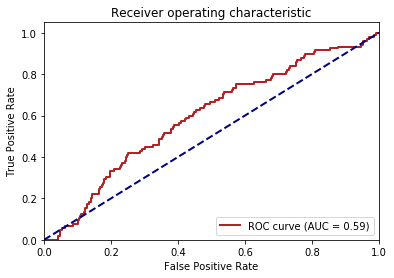

Average precision-recall score: 0.11


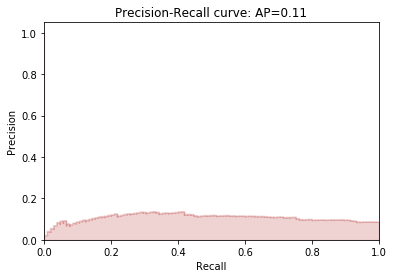

Best F1 score of  0.20465116279069767  achieved at threshold of  0.04356464233018899
Corresponding vales are: Precision  0.13538461538461538  Recall:  0.41904761904761906


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

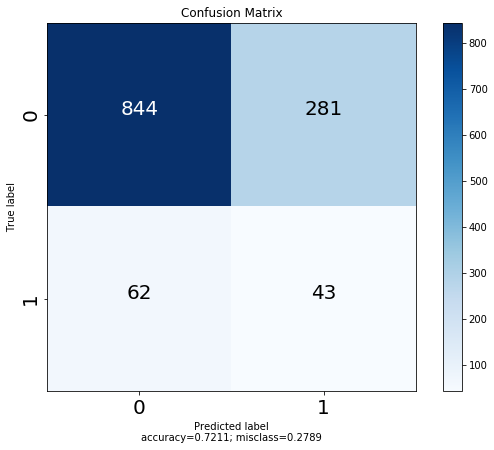

In [38]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_avg/recall.npy", recall)





#### Maximum

In [39]:
scores = np.amax(region_scores, axis=(1,2))

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.60


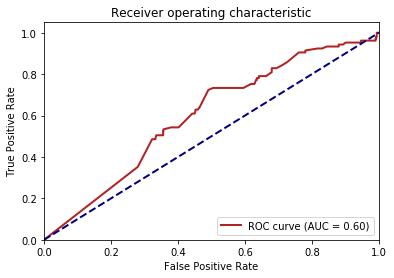

Average precision-recall score: 0.11


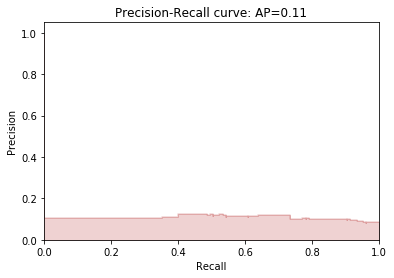

Best F1 score of  0.2073669849931787  achieved at threshold of  0.6667084693908691
Corresponding vales are: Precision  0.12101910828025478  Recall:  0.7238095238095238


<Figure size 432x288 with 0 Axes>

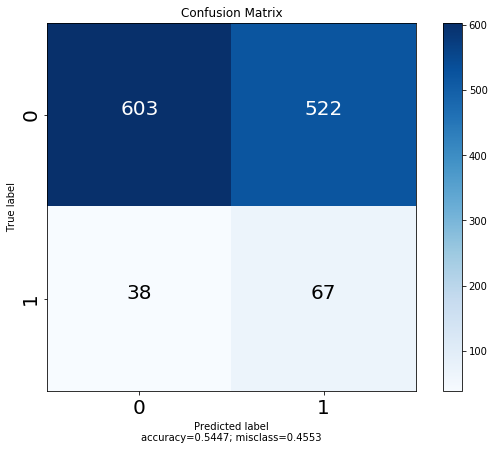

In [40]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)



np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_max/recall.npy", recall)





#### Variance in Error

In [41]:
print(region_scores.shape)
mean_reg_score = np.amax(region_scores, axis=0)
print(mean_reg_score.shape)

y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)


scores = np.zeros((X_test.shape[0]), dtype = np.float64)


for i, (reg_score,frameId,second_count)   in enumerate(zip(region_scores,Id_test,sec_count_test)):
    reg_score_numeric = np.array(reg_score, dtype = np.float64)
    var_arr = np.subtract(mean_reg_score,reg_score_numeric)
    #print(var_arr)
    #if 0 in var_arr:
        #print('Found 0')
    #var_arr = np.divide(1,var_arr)
    #if len(var_arr[np.isinf(var_arr)]) > 0:
        #print('some elements')
    #var = distance.sqeuclidean(np.ravel(reg_score_numeric),np.ravel(mean_reg_score))
    #print(np.amax(var_arr))
    scores[i] = np.amax(var_arr)
    
#print(scores)
#scores = np.divide(1,scores)
#print(scores)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])
    

(9838, 12, 20)
(12, 20)


ROC_AUC: 0.50


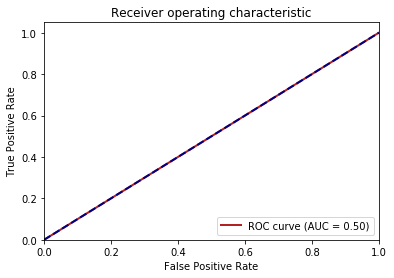

Average precision-recall score: 0.09


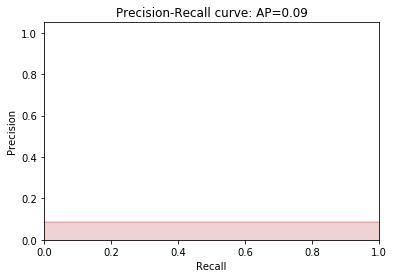

Best F1 score of  0.15730337078651685  achieved at threshold of  1.0
Corresponding vales are: Precision  0.08536585365853659  Recall:  1.0


<Figure size 432x288 with 0 Axes>

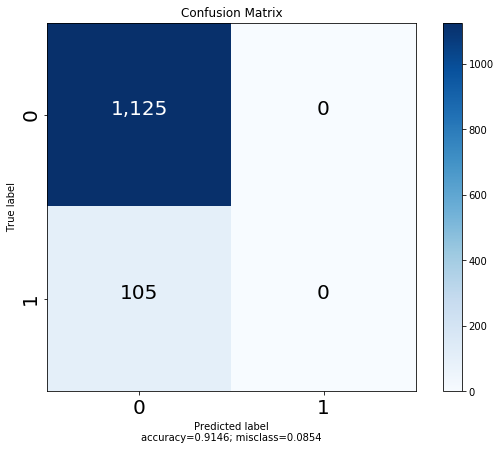

In [42]:
roc_auc, average_precision, F1_best, threshold_best, fpr, tpr, precision, recall = calc_metrics(y_gt_test, y_score_test, display_graphs=True)


np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/fpr.npy", fpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/tpr.npy", tpr)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/precision.npy", precision)
np.save("Results/curves/"+grid_type+"/region_based_autoencoder_var_error/recall.npy", recall)



